In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import re
import io
import matplotlib.pyplot as plt 
import torch 
import pickle
import numpy as np 
import importlib

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


# Personnal imports: 
from constants.paths import SAVE_DIRECTORY, FOLDER_PATH
from examples.load_best_config import get_trainer_and_ds_from_saved_trial
from examples.benchmark import local_get_args
from plotting.plotting import get_gain_from_mod1,get_y_size_from_temporal_agg,plot_coverage_matshow,get_df_mase_and_gains,gain_between_models,get_df_gains
from plotting.plotting import set_attention_weights_agregated_per_daily_period
from plotting.plotting_folium import plot_folium_map
from examples.train_model import load_init_model_trainer_ds
from plotting.TS_analysis import plot_TS
from dl_models.full_model import full_model
from trainer import Trainer
from examples.train_and_visu_non_recurrent import train_the_config,get_ds
from examples.train_model import main 
from utils.rng import set_seed
from jupyter_ipynb.utils import parse_results_to_dataframe,display_latex_df
from examples.accuracy_comparison import get_profil_per_horizon,plot_profile_comparison_between_2_prediction,get_predict_real_and_inputs,plot_daily_profile
from examples.accuracy_comparison import get_working_day_daily_profile_on_h,plot_analysis_comparison_2_config
from examples.accuracy_comparison import plot_attn_weights,get_calendar_mask
from examples.accuracy_comparison import get_previous_and_prediction, plot_gain_between_models_with_temporal_agg,load_trainer_ds_from_2_trials,print_global_info,load_trainer_ds_from_1_args

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Training and Hyper-parameter tuning with Ray is not possible



In [42]:
# La chaîne de caractères brute contenant tous les résultats.
from save.fast_training_str_results.subway_in_subway_out_bike_in_bike_out_1_trial_1year import results_string as results_string_1year
from save.fast_training_str_results.subway_in_subway_out_bike_in_bike_out_1_trial_77days import results_string as results_string_77days


# --- Load results 
results_df = parse_results_to_dataframe(results_string_1year,bis=True)
results_df['contextuals'] = results_df.apply(lambda row : '_'.join([ds_name for ds_name in ['subway_in','subway_out','bike_in','bike_out'] if row[ds_name]]),axis=1)
results_df['horizon'] = results_df['horizon'].apply(lambda h : int(h[1:-3]))
results_df['bis'] = results_df['bis'].astype(int)
results_df['id'] = results_df.apply(lambda row : f"{row['contextuals']}_h{row['horizon']}",axis=1)
# ---


# --- Add MASE:
subfolder = 'K_fold_validation/training_wo_HP_tuning/optim/subway_in_STGCN'
freq = 15 # 15min 
path_model_args = f"{SAVE_DIRECTORY}/{subfolder}/best_models"
model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))

list(model_args['model'].keys())


modifications_new = {}
for target_data in ['subway_out']:
    for horizon in [1,2,3,4]:
        for contextual_dataset_names in [['subway_in','bike_in'],['bike_in'],[],['subway_in']]: 
            for n_bis in range(1,6): # range(1,6):
                dataset_names =  [target_data] +contextual_dataset_names+ ['calendar_embedding']
                name_i = f"{'_'.join(dataset_names)}_h{horizon}_bis{n_bis}"
                model_args['model'][f"_{name_i}_f5"]

                idx = results_df[(results_df['contextuals'] == '_'.join(contextual_dataset_names)) & 
                                (results_df['horizon'] == horizon*freq) &
                                (results_df['bis'] == n_bis)
                                ].index
                assert len(idx) == 1, 'Several results for the same configuration, check the code'

                results_df.loc[idx[0], 'MASE'] = model_args['model'][f"_{name_i}_f5"]['performance']['test_metrics'][f'mase_h{horizon}']
# ---

# --- Plot Metrics : 

from jupyter_ipynb.NetMob_training_analysis.plotting import plot_boxplot_on_metric 
plot_boxplot_on_metric(results_df,metric_i='MAE',xaxis_label = 'config', legend_group = 'horizon', save_path=None)
# plot_boxplot_on_metric(results_df,metric_i='RMSE',xaxis_label = 'config', legend_group = 'horizon', save_path=None)
plot_boxplot_on_metric(results_df,metric_i='MASE',xaxis_label = 'config', legend_group = 'horizon', save_path=None)

Loading BokehJS ...

Loading BokehJS ...

# Comparison of 5 iterations of the same model: 

# Regroupement par cluster spatiaux 
### retourner des gains par types de stations qui se ressemblent. Distinguer celles qui se ressemble "le matin" de celle qui se ressemble "le soir". Essayer d'interpréter ce que représentent ces stations d'un point de vue socio-economique.

In [ ]:
from tslearn.metrics import dtw


# --- Method 2: Sequence-Based Clustering
def cluster_by_sequence_dtw(df: pd.DataFrame, n_clusters: int = 4) -> Dict[int, List[str]]:
    """
    Clusters time series based on the similarity of their average weekday morning peak sequence,
    using Dynamic Time Warping (DTW) as the distance metric.

    Args:
        df (pd.DataFrame): The input dataframe with time series as columns and a DatetimeIndex.
        n_clusters (int): The number of clusters to form.

    Returns:
        Dict[int, List[str]]: A dictionary mapping cluster labels to the list of series names.
    """
    # ---- Sequence Extraction and Averaging
    s_dates = df.index.to_series()
    morning_peak_mask = is_morning_peak(s_dates)
    weekday_mask = is_weekday(s_dates)
    df_filtered = df[morning_peak_mask & weekday_mask]

    # Group by date to get daily sequences, then average them for each series
    df_filtered['date'] = df_filtered.index.date
    df_filtered['time'] = df_filtered.index.time

    avg_sequences = {}
    for series_name in df.columns:
        # Pivot to have time as index and date as columns for one series
        daily_sequences = df_filtered.pivot(index='time', columns='date', values=series_name)
        # Calculate the mean sequence across all days
        avg_sequences[series_name] = daily_sequences.mean(axis=1).values
        
    representative_series = pd.DataFrame(avg_sequences)

    # ---- DTW Distance Matrix Calculation
    n_series = len(df.columns)
    dtw_dist_matrix = np.zeros((n_series, n_series))

    for i in range(n_series):
        for j in range(i, n_series):
            dist = dtw(representative_series.iloc[:, i], representative_series.iloc[:, j])
            dtw_dist_matrix[i, j] = dist
            dtw_dist_matrix[j, i] = dist
            
    # ---- Clustering
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
    labels = agg_cluster.fit_predict(dtw_dist_matrix)
    
    # ---- Formatting Output
    clusters = {i: [] for i in range(n_clusters)}
    for series_name, label in zip(df.columns, labels):
        clusters[label].append(series_name)

    # ---- Visualization
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3 * n_clusters), sharex=True)
    if n_clusters == 1: axes = [axes] # Ensure axes is iterable
    for i, (label, series_names) in enumerate(clusters.items()):
        ax = axes[i]
        for name in series_names:
            ax.plot(representative_series.index, representative_series[name], alpha=0.7)
        ax.set_title(f'Cluster {label} (DTW-based)')
        ax.set_ylabel('Value')
    ax.set_xlabel('Time step in morning peak')
    plt.tight_layout()
    plt.show()

    return clusters


# 3. Method 2: Sequence-based (DTW) Clustering
print("Running Method 2: Sequence-Based (DTW) Clustering...")
sequence_clusters = cluster_by_sequence_dtw(time_series_df, n_clusters=3)
print("Sequence (DTW) Clusters Found:")
for label, series in sequence_clusters.items():
    print(f"  Cluster {label}: {len(series)} series -> {series[:5]}...")
print("-" * 50)

In [46]:
df_copy_bis = df_copy.stack()
df_copy_bis.name = 'value'
df_copy_bis = df_copy_bis.reset_index()
df_copy_bis

,level_0,Station,value
0,2019-03-18 07:30:00,AMP,74.0
1,2019-03-18 07:30:00,BEL,250.0
2,2019-03-18 07:30:00,BRO,118.0
3,2019-03-18 07:30:00,CHA,461.0
4,2019-03-18 07:30:00,COR,127.0
...,...,...,...
8269,2019-04-30 09:00:00,GER,14.0
8270,2019-04-30 09:00:00,VMY,36.0
8271,2019-04-30 09:00:00,JEA,10.0
8272,2019-04-30 09:00:00,date,2019-04-30


Station,AMP,BEL,BLA,BON,BRO,CHA,COR,CPA,CRO,CUI,...,PAR,PER,PRY,REP,SAN,SAX,SOI,VAI,VEN,VMY
time,,,,,,,,,,,,,,,,,,,,,
07:30:00,98.892860,311.607147,447.571442,302.342834,140.964279,597.250000,147.571426,13.464286,171.571426,149.250000,...,518.357117,511.142853,179.750000,240.678574,298.750000,379.892853,570.071411,760.178589,484.142853,270.103577
07:45:00,146.607147,406.071442,595.071411,325.350006,167.071426,776.892883,179.285721,20.500000,187.607147,185.392853,...,576.214294,658.321411,211.178574,277.250000,409.000000,484.535706,561.500000,820.214294,470.928558,306.214294
08:00:00,120.535713,375.535706,485.928558,289.671417,149.035721,715.964294,176.892853,18.357143,160.035721,157.607147,...,600.392883,580.892883,172.357147,247.196426,359.821442,483.464294,454.250000,649.071411,384.714294,279.289276
08:15:00,97.642860,301.821442,387.285706,240.078583,121.571426,542.357117,150.214279,12.500000,148.964279,103.107140,...,410.035706,477.892853,143.464279,186.250000,270.142853,347.571442,371.428558,522.678589,332.857147,228.678574
08:30:00,97.892860,311.250000,379.678558,239.121429,116.035713,540.500000,137.964279,15.535714,147.321426,105.892860,...,432.142853,453.964294,136.964279,186.178574,255.392853,345.750000,362.821442,533.785706,301.214294,215.849991
08:45:00,107.500000,348.107147,412.589294,234.407135,110.214287,537.892883,149.285721,18.571428,142.250000,128.678574,...,437.607147,494.428558,143.392853,183.250000,299.228577,354.214294,345.571442,522.107117,289.928558,214.007156
09:00:00,83.000000,302.964294,338.535706,208.739288,91.000000,507.785706,143.571426,16.107143,111.750000,94.928574,...,427.589294,411.250000,114.392860,150.750000,228.678574,306.142853,254.321426,405.892853,206.035721,183.017853


In [ ]:
temporal_agg = 'morning_peak'
city = 'Lyon'

df_filtered = filter_by_temporal_agg(train_df, temporal_agg,city)



In [ ]:
# Clustering temporal series

# Faire le clusering uniquement sur la dataset de train sur les :
# 1: Working days 
    # 1.1 Morning peak 
    # 1.2 Evening Peak 
    # 1.3 Off peak 

# 2: Bank holidays 
    # 1.1 Morning peak 
    # 1.2 Evening Peak 
    # 1.3 Off peak 




import pandas as pd
import numpy as np
import datetime
from typing import Dict, List

# Visualization and Clustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from calendar_class import is_morning_peak, is_weekday, is_evening_peak, is_bank_holidays, is_morning, is_evening

def get_mask_working_day(s_dates,mask_specific_period,city):
    weekday_mask = is_weekday(s_dates)
    dates_is_bank_holidays = s_dates.apply(lambda x: is_bank_holidays(x,city= city))
    filter_mask = mask_specific_period & weekday_mask & ~dates_is_bank_holidays
    return filter_mask

def filter_by_temporal_agg(df: pd.DataFrame, temporal_agg: str, city : str) -> pd.DataFrame:
    s_dates = df.index.to_series()

    if temporal_agg == 'morning_peak':
        filter_mask = get_mask_working_day(s_dates,is_morning_peak(s_dates),city)
    elif temporal_agg == 'evening_peak':
        filter_mask = get_mask_working_day(s_dates,is_evening_peak(s_dates),city)
    elif temporal_agg == 'off_peak':
        filter_mask = get_mask_working_day(s_dates,~is_morning_peak(s_dates) & ~is_evening_peak(s_dates),city)

    elif temporal_agg == 'bank_holiday':
        filter_mask = s_dates.apply(lambda x: is_bank_holidays(x,city= city))
    elif temporal_agg == 'morning':
        filter_mask = get_mask_working_day(s_dates,is_morning(s_dates),city)
    elif temporal_agg == 'evening':
        filter_mask = get_mask_working_day(s_dates,is_evening(s_dates),city)
    else: 
        raise ValueError(f"Unknown temporal aggregation: {temporal_agg}")
    
        
    df_filtered = df[filter_mask]
    return df_filtered


def compute_gmm_clustering(df: pd.DataFrame, n_clusters: int = 4, covariance_type: str = 'full') -> np.ndarray:
    """
    Computes clusters from time series data using a Gaussian Mixture Model.
    It works by creating an average profile for each series and clustering these profiles.
    """
    # ---- Data Preparation: Create representative profiles
    df_copy = df_filtered.copy()
    df_copy_bis = df_copy.stack()
    df_copy_bis.name = 'value'
    df_copy_bis = df_copy_bis.reset_index()
    df_copy_bis['time'] = df_copy_bis.level_0.dt.time
    df_copy_bis['date'] = df_copy_bis.level_0.dt.date
    representative_series_df = df_copy_bis.pivot_table(index = 'Station',columns = 'time', values = 'value', aggfunc = 'mean')
    data_for_clustering = representative_series_df.values   # GMM expects data of shape (n_samples, n_features)
    
    # ---- Clustering
    model = GaussianMixture(
        n_components=n_clusters,
        covariance_type=covariance_type,
        random_state=42
    )
    labels = model.fit_predict(data_for_clustering)

    # ---- Visualization of clustered profiles
    clusters = {i: [] for i in range(n_clusters)}
    for series_name, label in zip(representative_series_df.columns, labels):
        clusters[label].append(series_name)
    
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3 * n_clusters), sharex=True)
    if n_clusters == 1: axes = [axes] # Ensure axes is iterable

    for i, (label, series_names) in enumerate(clusters.items()):
        ax = axes[i]
        for name in series_names:
            ax.plot(representative_series_df.index.astype(str), representative_series_df[name], alpha=0.6)
        ax.set_title(f'Cluster {label} (GMM-based Profiles)')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)
    
    ax.set_xlabel('Time of Day')
    plt.tight_layout()
    plt.show()

    return labels



def compute_agglomerative_clustering(df: pd.DataFrame, n_clusters: int = 4, metric: str = 'correlation',linkage: str ='complete') -> List[int]:
    """ Computes clusters from time series data using agglomerative clustering.
    It works by calculating a distance matrix based on the correlation of time series.
    """
    # ---- Distance Matrix Calculation
    corr_matrix = df.corr()
    dist_matrix = 1 - np.abs(corr_matrix)


    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
    labels = agg_cluster.fit_predict(dist_matrix)
    
    # ---- Dendrogram Visualization
    linked = linkage(dist_matrix, method=linkage)
    plt.figure(figsize=(15, 6))
    dendrogram(linked, orientation='top', labels=corr_matrix.index, distance_sort='descending')
    plt.title('Dendrogram of Time Series (Correlation-based)')
    plt.ylabel('Distance (1 - |correlation|)')
    plt.tight_layout()
    plt.show()

    # --- Heatmap of the correlation matrix, ordered by cluster
    clustered_series = corr_matrix.columns[np.argsort(labels)]
    sns.clustermap(corr_matrix.loc[clustered_series, clustered_series], 
                row_cluster=False, col_cluster=False, 
                cmap='viridis', figsize=(10, 10))
    plt.suptitle('Correlation Matrix Heatmap (Ordered by Cluster)', y=1.02)
    plt.show()

    return labels


# --- Method 1: Correlation-Based Clustering
def clustering(df: pd.DataFrame, 
                           n_clusters: int = 4, 
                           temporal_agg: str = 'morning_peak',
                           clustering_method = 'agglomerative',
                           linkage: str = 'complete',
                           metric: str =  'correlation',
                           covariance_type: str = 'full',
                           city: str = 'Paris'
                           ) -> Dict[int, List[str]]:
    """
    Clusters time series based on a specified method and temporal window.

    Args:
        df (pd.DataFrame): Input dataframe with time series as columns.
        n_clusters (int): The number of clusters to form.
        temporal_agg (str): The temporal window to filter data on.
        clustering_method (str): The clustering algorithm to use. Options: ['agglomerative', 'GMM'].
        linkage (str): Linkage method for agglomerative clustering.
        covariance_type (str): Covariance type for GMM.
        city (str): City name for holiday calendar.

    Returns:
        Dict[int, List[str]]: A dictionary mapping cluster labels to series names.
    """
    # ---- Filtering
    df_filtered = filter_by_temporal_agg(df, temporal_agg,city)

    # ---- Clustering
    if clustering_method == 'agglomerative':
        labels = compute_agglomerative_clustering(df = df_filtered, n_clusters = n_clusters, metric = metric,linkage=linkage)

    elif clustering_method == 'GMM':
        # GMM works on feature vectors (our time series profiles), not distance matrices
        labels = compute_gmm_clustering(df_filtered, n_clusters=n_clusters, covariance_type=covariance_type)
        
    else:
        raise ValueError(f"Unknown clustering method: {clustering_method}. Choose from ['agglomerative', 'GMM'].")


    # ---- Formatting Output
    clusters = {i: [] for i in range(n_clusters)}
    for series_name, label in zip(df.columns, labels):
        clusters[label].append(series_name)
        
    return clusters


In [5]:
# Load datasets use for training : 
train_input = ds2.train_input
train_time_slots = ds2.tensor_limits_keeper.df_verif_train.stack().unique()
train_df = pd.DataFrame(train_input.numpy(),index = train_time_slots,columns = ds2.spatial_unit)
train_df = train_df.reindex(pd.date_range(start=train_df.index.min(),end=train_df.index.max(),freq='15min'))

In [ ]:

# 2. Method 1: Correlation-based Clustering
print("Running Method 1: Correlation-Based Clustering...")
correlation_clusters = clustering(df = train_df, 
                                    temporal_agg = 'morning_peak',
                                    clustering_method = 'agglomerative',
                                    n_clusters=4,
                                    city = ds2.city)
print("Correlation Clusters Found:")
for label, series in correlation_clusters.items():
    print(f"  Cluster {label}: {len(series)} series -> {series[:5]}...")
print("-" * 50)

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

>>>Loading calendar embedding inputs ...
    dict_keys(['dayofweek_OHE', 'hour_OHE'])
   args_embedding.variable_selection_model_name:  MLP
Init U/Utarget size: torch.Size([4699, 40, 7])/torch.Size([4699, 40, 4]) Train/Valid/Test 2819 940 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

----------------------------------------
Loadi

Loading BokehJS ...

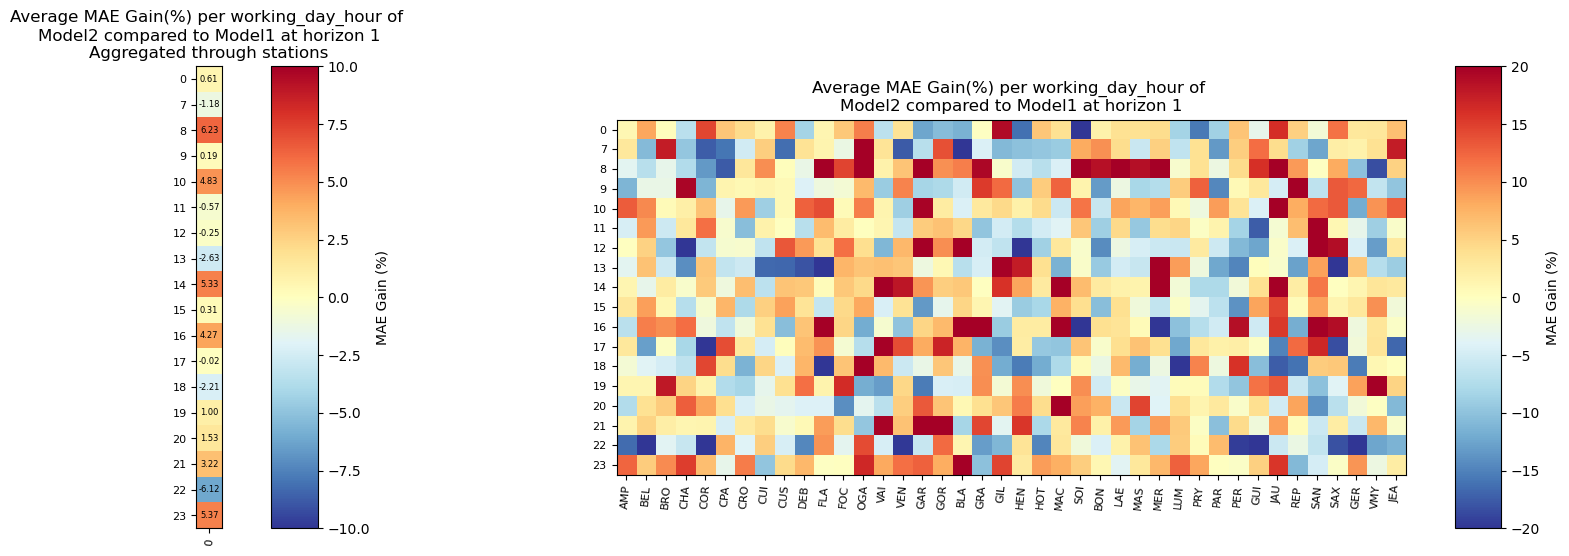

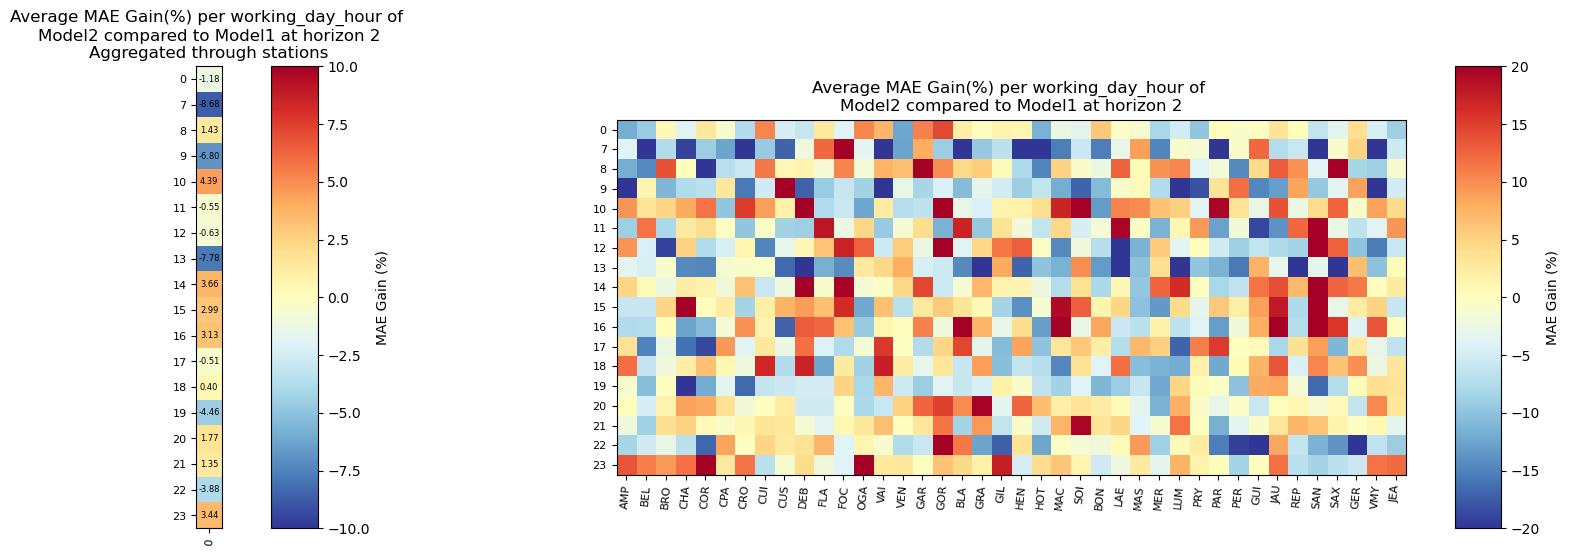

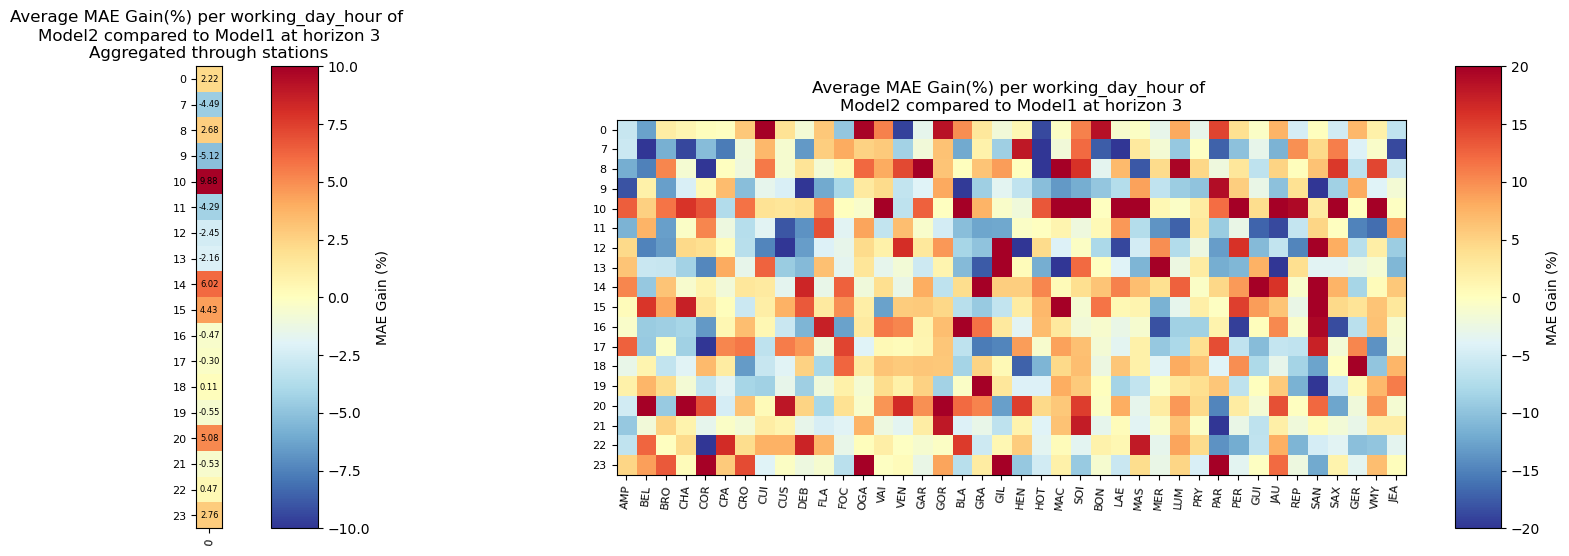

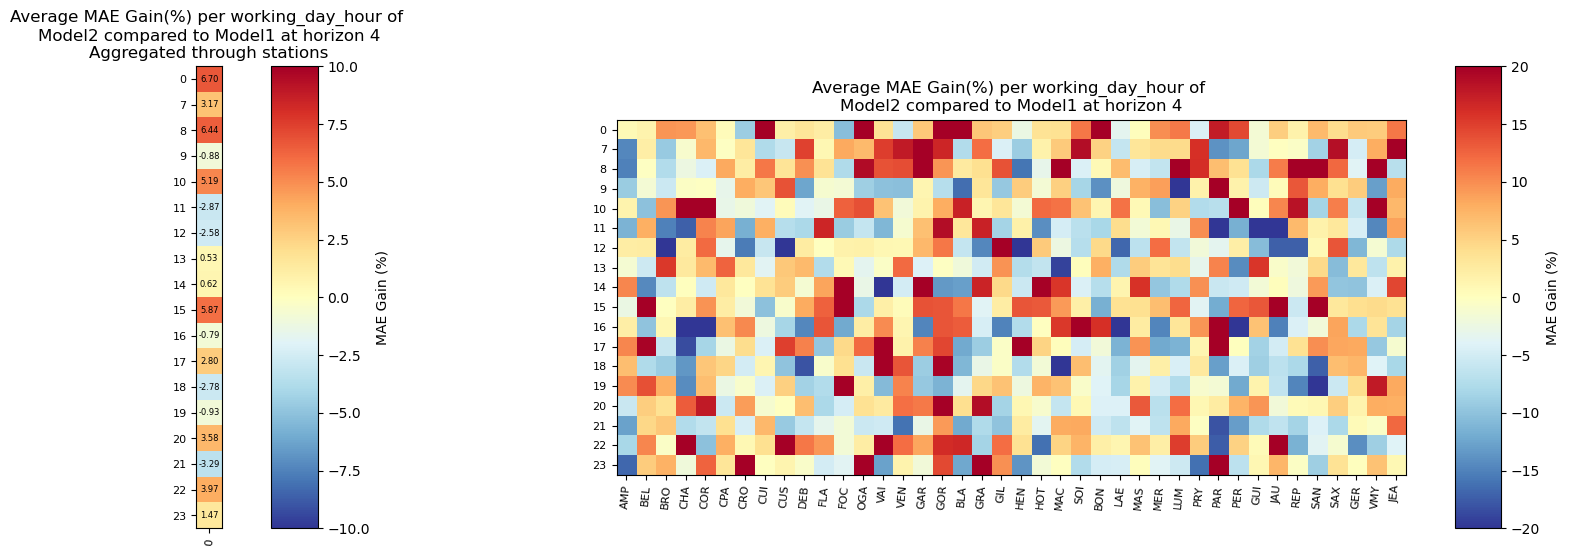

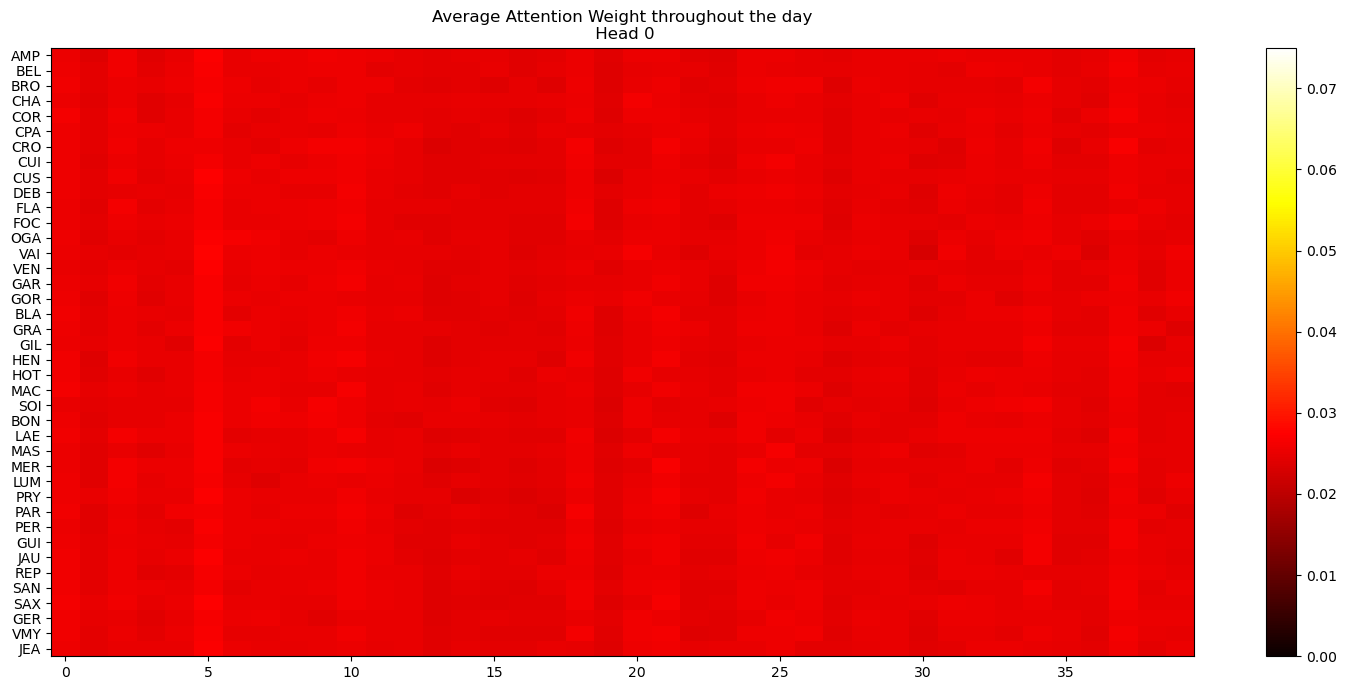

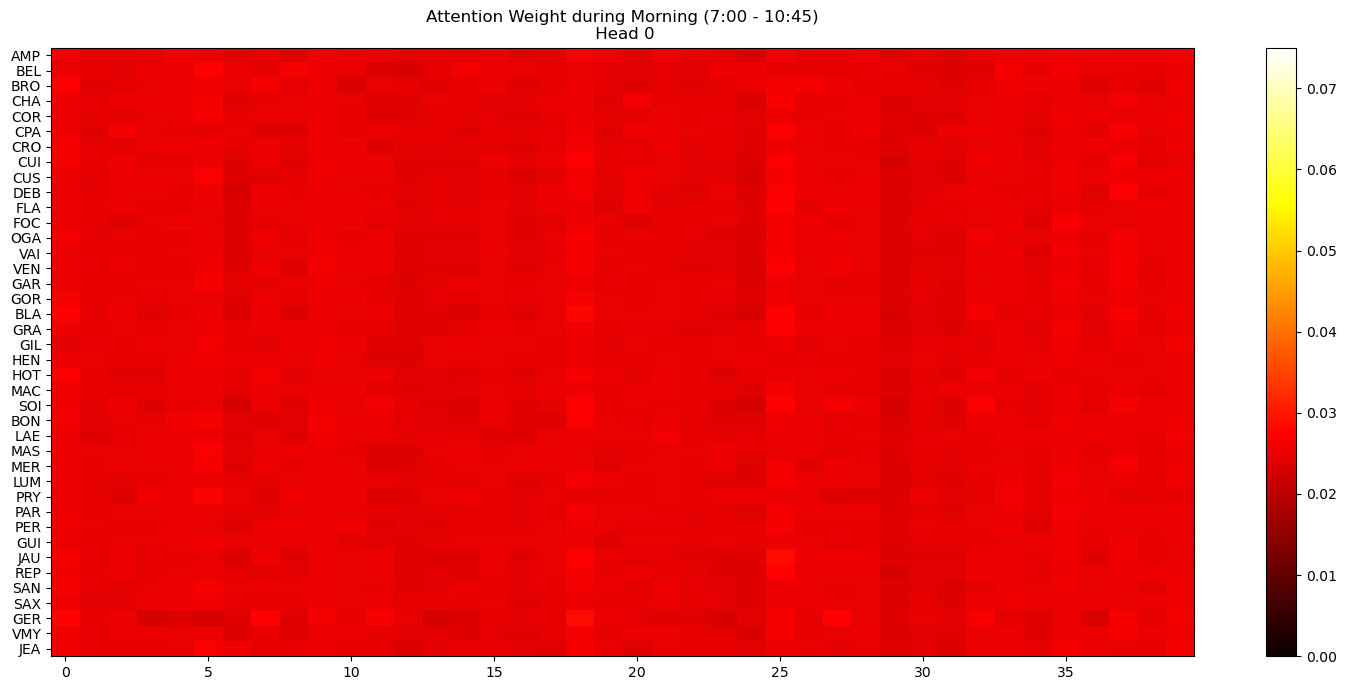

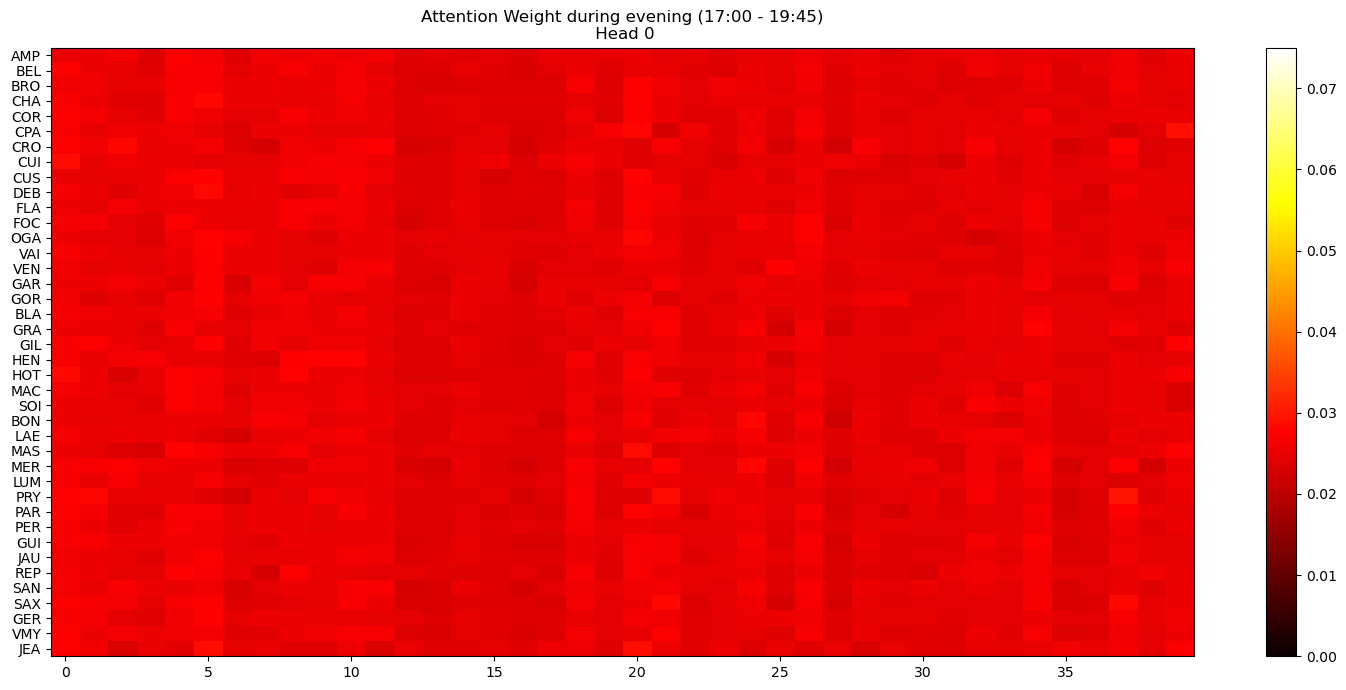

In [4]:
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
training_mode = 'test'


## -----------------FULL DATA 1 AN---------------------------------------------------------------------------------------------------------
## Prediction on 4 consecutives horizons 

# ## Prediction on HORIZON 1
# trial_id1 = 'subway_out_calendar_embedding_h1_bis'
# trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h1_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h1_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h1_bis'

# ## Prediction on HORIZON 2
# trial_id1 = 'subway_out_calendar_embedding_h2_bis'
# trial_id1 = 'subway_out_subway_in_calendar_embedding_h2_bis'
# trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h2_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h2_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h2_bis'

# ## Prediction on HORIZON 3
# trial_id1 = 'subway_out_calendar_embedding_h3_bis'
# trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h3_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h3_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h3_bis'

# ## Prediction on HORIZON 4
# trial_id1 = 'subway_out_calendar_embedding_h4_bis'
# trial_id2 = 'subway_out_subway_in_bike_in_calendar_embedding_h4_bis'
# trial_id2 = 'subway_out_subway_in_calendar_embedding_h4_bis'
# trial_id2 = 'subway_out_bike_in_calendar_embedding_h4_bis'

## ------------------------------------------------------------------------------------------------------------------------------------------------



## ------------------------------------------------------------------------------------------------------------------------------------------------
## Prediction on 4 consecutives horizons 
trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered'  
trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered'
# # trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered'
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered'

## Prediction on HORIZON 1
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'  
# trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'         # Pas d'intéret 
# trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'   #  Intérêt de Bike-in     // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h1'  # Pas d'intérêt 

## Prediction on HORIZON 2
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'  
# trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'         # Intérêt aprem jusqu'a 20h    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'   # Intérêt 7h et 9h. Vraiment pas bon 8h. très léger gains  aprem jusqu'a 20h    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h2'  # Très mauvais partout 

## Prediction on HORIZON 3
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'  
# trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'       # Très très gros gain le matin    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'    # Très très gros gain le matin    // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h3'  # Pas de gain notable, pas mal de rouge (7,16,21h)


## Prediction on HORIZON 4
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'  
# # trial_id2 = 'subway_in_subway_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'         # Grosse Perte matin, gros gain pic du soir. // Attention pas utile  
# # trial_id2 = 'subway_in_subway_out_bike_in_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'      # Grosse Perte matin, gros gain pic du soir. // Attention pas utile 
# trial_id2 = 'subway_in_subway_out_bike_in_bike_out_calendar_emb64_out64_Huber_MinMax_outlier_filtered99_h4'  # enorme perte minuit (30%), gain soir. // Attention pas utile

## ------------------------------------------------------------------------------------------------------------------------------------------------




# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis'   

# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon1_bis'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon2_bis'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon3_bis'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon4_bis'


## --- Top K Horizon 2 prometteur :
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon2_bis'
## --- Top K : 


# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed' #(topk = 20)    # MSE 1507 Gain vraiment bon + Attention Ok
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30'                 # MSE 1494 Gain très bizarre, attention Ok/bizarre

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon1_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon3_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top10_horizon4_bis'

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon1_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon3_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top20_horizon4_bis'






# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon2_bis'
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon3_bis'     # Gain matin faible reste mauvais, Graph Analysable 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed_top30_horizon4_bis'   # Gain matin, Graph Analysable 
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon4_bis'  
# trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon4_bis2'
                                                                                                   # MSE moyen: 1512.70, Référence 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_ff128_h1_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'    # MSE moyen : 1529.99  Gain matin bof ok.. // ATTN WEIGHT INCOHERENT
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_h4_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'          # MSE moyen : 1522.9, leger gain matin // ATTN WEIGHT UNIFORM
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_h4_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'           # MSE moyen : 1529.77, léger gain matin mais pas hyper coherent // ATTN WEIGHT 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_ff128_h1_l2_unormalized_loss_concatenated_L_out4_outliers_removed_attn_late_bis'     # MSE moyen : 1522.878, Gain Matin horizon 2/3/4, sinon 21h à h1 // ATTN WEIGHT 

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim48_ff64_h2_l2_unormalized_loss_concatenated_L_out4_bis'                    # MSE moyen: 1521.41, Gains Matin ok // ATTN WEIGHT UNIFORM
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim48_ff64_h2_l2_unormalized_loss_concatenated_L_out4_outliers_removed_bis'   # MSE moyen: 1522.35, Gain Intéressant, plutôt matin // ATTN WEIGHT INCOHERENT
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff256_h1_l1_unormalized_loss_concatenated_outliers_removed'               # MSE 1500 ATTENTION UNIFORM

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h1_l8_unormalized_loss_concatenated_L_out32_bis'                 # MSE moyen: 1526.77, Gain matin 8/9h
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h1_l8_unormalized_loss_concatenated_L_out32_outliers_removed_bis'  # MSE moyen: 1567.12, très mauvais 

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out4_bis'                  # MSE moyen: 1544.90, Gain pas clair, pas on 7h
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim32_ff64_h1_l8_unormalized_loss_concatenated_L_out32_bis'                   # MSE moyen: 1540.27, Gain Off-peak et horizon3 9h
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim32_ff128_h1_l16_unormalized_loss_concatenated_L_out32_bis'                 # MSE moyen: 1539.28, Gain 8 am fort, sinon non, voir léger off-peak
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff64_h1_l16_unormalized_loss_concatenated_L_out4_bis'                   # MSE moyen: 1534.28, Gain 20-22h mais globalement bof 
# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h1_l16_unormalized_loss_concatenated_L_out32_bis'                # MSE moyen: 1549.52, Très peu de gain, gloalement très mauvais

# trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim32_ff64_h1_l8_unormalized_loss_concatenated_L_out32_bis'                    # MSE moyen: 1532.12, Gain matin assez fort 8/9h // ATTN WEIGHT 

subfolder = 'K_fold_validation/training_wo_HP_tuning/optim/subway_in_STGCN'
path_model_args = f"{SAVE_DIRECTORY}/{subfolder}/best_models"
model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))

if trial_id2.endswith('bis'):
    try : 
        #  ----  Load saved models and predictions  ---- 
        range_k = range(1,6)
        for k in range_k: # range(1,6):
            trial_id1_updated = f"_{trial_id1}{k}_f5"
            trial_id2_updated = f"_{trial_id2}{k}_f5"
            trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,model_args=model_args,path_model_args=path_model_args)
            full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)
            globals()[f"trainer1_bis{k}"] = trainer1
            globals()[f"trainer2_bis{k}"] = trainer2
            globals()[f"ds1_bis{k}"] = ds1
            globals()[f"ds2_bis{k}"] = ds2
            globals()[f"full_predict1_bis{k}"] = full_predict1
            globals()[f"full_predict2_bis{k}"] = full_predict2
    except: 
        range_k = range(1,2)
        for k in range_k:
            trial_id1_updated = f"_{trial_id1}{k}_f5"
            trial_id2_updated = f"_{trial_id2}_f5"
            trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,model_args=model_args,path_model_args=path_model_args)
            full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)
            globals()[f"trainer1_bis{k}"] = trainer1
            globals()[f"trainer2_bis{k}"] = trainer2
            globals()[f"ds1_bis{k}"] = ds1
            globals()[f"ds2_bis{k}"] = ds2
            globals()[f"full_predict1_bis{k}"] = full_predict1
            globals()[f"full_predict2_bis{k}"] = full_predict2

else:
    range_k = range(1,2)
    trial_id1_updated = f"_{trial_id1}_f5"
    trial_id2_updated = f"_{trial_id2}_f5"
    trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,model_args=model_args,path_model_args=path_model_args)
    full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)
    globals()[f"trainer1_bis1"] = trainer1
    globals()[f"trainer2_bis1"] = trainer2
    globals()[f"ds1_bis1"] = ds1
    globals()[f"ds2_bis1"] = ds2
    globals()[f"full_predict1_bis1"] = full_predict1
    globals()[f"full_predict2_bis1"] = full_predict2

full_predict1 = torch.stack([globals()[f"full_predict1_bis{k}"] for k in range_k]).mean(0)
full_predict2 = torch.stack([globals()[f"full_predict2_bis{k}"] for k in range_k]).mean(0)

temporal_aggs =   ['working_day_hour'] # ['daily_period','working_day_hour','weekday_hour_minute'] # ['hour','date','weekday'] 'hour', 'date', 'weekday', 'weekday_hour', 'weekday_hour_minute', 'daily_period', 'working_day_hour'
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)

metric_list = ['mae'] # ['mae','mase','rmse']
# ---- 

# ---- Plot Accuracy Comparison ---- 
plot_analysis_comparison_2_config(trial_id1,trial_id2,full_predict1,full_predict2,Y_true,X,ds1,args_init1,
                                      stations,temporal_aggs,training_mode,metric_list,min_flow = 20,station = 'COR')
# ----

# ---- Plot Attention Weights ---- 
if hasattr(args_init2,'contextual_kwargs') and len(args_init2.contextual_kwargs) > 0:
    contextual_datasets = list(args_init2.contextual_kwargs.keys())
    for contextual_dataset in contextual_datasets:
        NetMob_attn_weights = []
        for trainer in [globals()[f"trainer2_bis{k}"] for k in range_k]:
            X = torch.cat([x for x,y,x_c  in trainer.dataloader['test']]).to(args_init2.device)
            Y = torch.cat([y for x,y,x_c  in trainer.dataloader['test']]).to(args_init2.device)
            nb_contextual = len(next(iter(trainer.dataloader['train']))[2])
            Xc = [torch.cat([x_c[r] for x,y,x_c  in trainer.dataloader['test']]).to(args_init2.device) for r in range(nb_contextual)]
            model = trainer.model
            model.eval()
            with torch.no_grad():
                pred = model(X,Xc)
            try: 
                test_NetMob_attn_weights = getattr(trainer.model.spatial_attn_poi,contextual_dataset).attn_weight
            except:
                try: 
                    test_NetMob_attn_weights = getattr(trainer.model.core_model.output.ModuleContextualAttnLate,contextual_dataset).attn_weight
                except:
                    test_NetMob_attn_weights = getattr(trainer.model.spatial_attn_poi,contextual_dataset).mha_list[-1].attn_weight
            NetMob_attn_weights.append(test_NetMob_attn_weights)
        NetMob_attn_weights = torch.stack(NetMob_attn_weights,0).mean(0)


        spatial_unit = ds2.spatial_unit
        s_dates = ds2.tensor_limits_keeper.df_verif_test.iloc[:,-1].reset_index(drop=True)
        plot_attn_weights(NetMob_attn_weights,s_dates,
                        #   weekdays,hours,
                        spatial_unit)

        # plot_attn_weights(test_NetMob_attn_weights,weekdays,hours,spatial_unit) # only attn weights of the last model just to visualize if attention weights are different across models 
        # ----


In [54]:
'_subway_in_calendar_emb64_out64_Huber_MinMax_bis1_f5' in model_args['model'].keys()

True

In [43]:
import geopandas as gpd 
# ---- Load gdf ----
# Find correspondence between attn weights and concerned netmob zones/apps:
for contextual_dataset in contextual_datasets:
    list_correspondence = args_init2.contextual_kwargs[contextual_dataset]['list_correspondence']
    dictionnary_aggregated_iris = args_init2.contextual_kwargs[contextual_dataset]['dictionnary_aggregated_iris']
    dict_label2agg = args_init2.contextual_kwargs[contextual_dataset]['dict_label2agg']

    dict_agg2label = {}
    for k,v in dict_label2agg.items():
        if v not in dict_agg2label:
            dict_agg2label[v] = []
        dict_agg2label[v].append(k)


    # Load gdf : 
    agg_iris_target_n = args_init2.contextual_kwargs[contextual_dataset]['agg_iris_target_n']
    if agg_iris_target_n is not None: 
        gdf = gpd.read_file(f"{FOLDER_PATH}/lyon_iris_agg{agg_iris_target_n}")
    else:
        gdf = gpd.read_file(f"{FOLDER_PATH}/lyon_iris_shapefile")
    # ----


    # ---- Set Parameter for the map visualization ----
    station = 'CHA' # HOT: 'hotel de ville'

    station_i = list(ds2.spatial_unit).index(station)
    head = 0

    for temporal_group in ['evening_peak','morning_peak']:
        mask = get_calendar_mask(s_dates,temporal_group = temporal_group,city=None)   # mask_morning  # mask_evening # mask_off_peak # mask_7 # # mask_8 # mask_9 # mask_16 # mask_17 # mask_18 # mask_21 # mask_22 # mask_23
        # Time Slot 0, Head 0, Station 0:
        uniform_weights = 1/NetMob_attn_weights.size(-1)
        VMIN = 0.5*uniform_weights
        VMAX = 3*uniform_weights #2*uniform_weights
        CMAP = 'OrRd'

        print('Size of NetMob_attn_weights: ',NetMob_attn_weights.size())
        print('Uniform weights: ', uniform_weights, 'Vmin: ',VMIN, 'Vmax: ',VMAX)   

        globals()[f"gdf_copy_{temporal_group}"] = set_attention_weights_agregated_per_daily_period(gdf,NetMob_attn_weights, 
                                                            station_i,head, mask, agg_iris_target_n,
                                                            dict_agg2label,list_correspondence)

        for app_tag_mode in ['Google_Maps_iris_DL','Web_Weather_iris_DL']:
            print(f"Plotting Attention Weights for {app_tag_mode} at {station} ({temporal_group})") 
            m_google_maps =plot_folium_map(FOLDER_PATH, globals()[f"gdf_copy_{temporal_group}"], app_tag_mode=app_tag_mode,
                                    spatial_unit = list(ds2.spatial_unit), station_i=station_i, VMIN=VMIN, VMAX=VMAX)
            display(m_google_maps)

KeyError: 'list_correspondence'

# Compare 2 models: 

## Load 2 trained models:

In [ ]:
print('Current position: ',os.getcwd())

modification = {'shuffle':False,
                'data_augmentation':False
                }
station = 'PER'

if False:
    save_path =  f"{SAVE_DIRECTORY}/K_fold_validation"  
    if_hp_tuning = 'training_wo_HP_tuning/optim' # or 'training_with_HP_tuning'  or 'training_wo_HP_tuning'  or 'training_wo_HP_tuning/optim
    path_model_args = f"{save_path}/{if_hp_tuning}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))


## Reference (1) : Best model STAEformer WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False:
    trial_id1 = 'subway_in_calendar_STAEformer_HuberLossLoss_2025_06_17_14_30_17612_F6_f5'
    trial_id2 = 'subway_in_calendar_netmob_POIs_STAEformer_HuberLossLoss_2025_06_17_11_32_17612_F6_f5'


## Reference (1) : Best model STAEformer WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False:
    trial_id1 = 'calendar_input_dim24'   # MAE = 22.54, MSE = 1612.03
    trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering02' # MAE = 22.47, MSE = 1576.47    # [Google Maps, Deezer]
    # trial_id2 = 'calendar_Google_Maps_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering02' #  MAE = 22.55, MSE = 1593.66  [ Google Maps]
    # trial_id2 = 'calendar_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering01' # MAE = 22.61, MSE = 1601.93  [Deezer]

    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"

## Reference (1) : Best model STGCN WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False:
    if_hp_tuning = 'training_wo_HP_tuning'  
    path_model_args = f"{save_path}/{if_hp_tuning}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))
    trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis'
    #trial_id2 ='subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_keep_topk'    # Très clair Horizon 1 Morning ou Week-end ~14h début de déplacement, voir même légèrement horizon 2/3, sinon peu utile si ce n'est en off-peak 
    #trial_id2 ='subway_in_calendar_emb64_out64_Huber_MinMax_Deezer_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_keep_topk_clustering01' # Horizon 1, sinon peu utile si ce n'est en off-peak 
    trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering01'  # Idem


## Reference (1) : Best model STGCN WITHOUT NetMob 
## Comparison (2):  With NetMob POIs:
if False: 
    trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'      # MAE = 21.57, MSE = 1474.81  [ None ]
    trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim48_ff128_h3_l2_clustering_015_MinMax'   
    ### MinMax: 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_02_MinMax'   # MAE = 21.98, MSE = 1520.98  [Google Maps, Deezer]
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_MinMax'          # MAE = 21.79, MSE = 1524.94  [Google Maps]
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_MinMax'               # MAE = 22.00, MSE = 1525.65  [Deezer]

    ### Standardize: 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_standardize' # MAE = 22.07, MSE = 1527.94 [Google Maps, Deezer]
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_01_standardize'      # MAE = 22.26, MSE = 1580.75  [Google Maps] 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Deezer_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_clustering_015_standardize'          # MAE = 22.14, MSE = 1590.85  [Deezer]

    ### Keep Top K (pas bon)
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_IRIS_attn_dim64_ff64_h2_l2_exp_smooth08_keep_topk'                     # MAE = 22.16, MSE = 1571.99  [Google Maps]

    ### Standardize: 
    # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_Standardize'                                                                                # MAE = 21.95, MSE = 1506.55  [ None ]

    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"

if True:
    # Best Trained Models : 
    if False:
        # STGCN
        trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'
        # trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Deezer_IRIS_attn_dim48_ff128_h3_l2_clustering_015_MinMax'
        trial_id2 = 'subway_in_calendar_emb64_out64_Huber_MinMax_Google_Maps_Web_Weather_Deezer_IRIS_attn_dim48_ff128_h3_l3_clustering_015_MinMax'

    if False:
        trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'
        trial_id2 = 'subway_in_calendar_Bike_IN_bike_OUT_emb64_out64_Huber_MinMax_attn_dim48_agg_IRIS_100_threshold_1_ff128_h3_l3'
        # trial_id2 = 'subway_in_calendar_bike_OUT_emb64_out64_Huber_MinMax_attn_dim48_agg_IRIS_100_threshold_1_ff128_h3_l3'
        # trial_id2 = 'subway_in_calendar_Bike_IN_emb64_out64_Huber_MinMax_attn_dim48_agg_IRIS_100_threshold_1_ff128_h3_l3'

    if False:
        # STAEformer
        trial_id1 = 'calendar_input_dim24'
        trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08_clustering02'
    if True:
        # trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax'       # MAE = 21.71, MSE = 1508.92
        # trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis1'  # MAE = 21.82, MSE = 1528.03
        trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis2'  # MAE = 21.67, MSE = 1500.71
        # trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis3'  # MAE = 21.76, MSE = 1531.69

        ## ---- Agg 100 Zones ----
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim48_ff64_h2_l2_unormalized_loss_concatenated_L_out4'      # MAE = 21.60, MSE = 1500.53 -> Gain Matin 
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff64_h4_l2_unormalized_loss_concatenated_L_out4'      # MAE = 21.58, MSE = 1505.71 -> Gain Matin 
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l8_unormalized_loss_concatenated_L_out64'   # MAE = 22.04, MSE = 1530.58 -> Gain Matin
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out16'  # MAE = 21.89, MSE = 1524.35 -> Gain Matin
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out32'  # MAE = 22.13, MSE = 1576.71 -> Gain Matin tot ,horizon 1 
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l4_unormalized_loss_concatenated_L_out4'    # MAE = 21.75, MSE = 1509.29 -> Gain Matin 8h horizon 1, et fort gain horizon 3 et 4

        ## ---- Agg 30 Zones ----
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out4'    # MAE = 21.87, MSE = 1499.16 --> MAUVAIS: Gain Matin horizon 4 seulement
        # trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim64_ff64_h4_l2_unormalized_loss_concatenated_L_out4'       # MAE = 21.60, MSE = 1499.48 --> BIZARRE : Gain 9-10h horizon 3 et très fort h4
        trial_id2 = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l8_unormalized_loss_concatenated_L_out4'     # MAE = 21.87, MSE = 1524.24 --> BIZARRE : Gain 9h fort  horizon 3 et 4


        ## ---- Autres ----
        # trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_input_dim24_attn_dim64_ff64_h2_ldim2_exp_smooth_08'
    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"
    subfolder = 'K_fold_validation/training_wo_HP_tuning/optim/subway_in_STGCN'
    path_model_args = f"{SAVE_DIRECTORY}/{subfolder}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))


## CRITER 
if False:
    station = 292  # [292,64,66,1000] #[893,67,999,65,291,1176]
    subfolder = 'training_wo_HP_tuning/optim/CRITER_3_4_5_lanes_flow_STAEformer'  # 'training_wo_HP_tuning/optim/CRITER_3_4_5_lanes_flow_STGCN'   # CRITER_3_4_5_lanes_flow_STGCN
    path_model_args = f"{save_path}/{subfolder}/best_models"
    model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))
    trial_id1 = 'Init'
    trial_id2 = 'calendar_Google_Maps_Deezer_IRIS_clustering015'

    trial_id1 = f"_{trial_id1}_f5"
    trial_id2 = f"_{trial_id2}_f5"
    

trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1,trial_id2,modification = modification,model_args=model_args,path_model_args=path_model_args)

In [19]:
training_mode = 'test'
full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode)

In [20]:
station = 'CUS'

# Load DF
profil_real,profil1_per_horizon,profil2_per_horizon = get_profil_per_horizon(full_predict1,full_predict2,Y_true,ds1,ds2,args_init1,args_init2)
df_std = get_working_day_daily_profile_on_h(args_init1.step_ahead,Y_true,ds1.tensor_limits_keeper.df_verif_test,ds1,args_init1, std = True,coeff_std = 1.0)

# Extract data on specific station: 
std_profil_station_i = df_std[station].copy()
profil_real_station_i = pd.DataFrame(profil_real[f"Real {station}"])
daily_profil1_station_i = pd.concat([profil1_per_horizon[h][f"Model1 {station} h{h}"] for h in range(args_init1.horizon_step, args_init1.step_ahead+1,args_init1.horizon_step)],axis = 1)
daily_profil2_station_i  = pd.concat([profil2_per_horizon[h][f"Model2 {station} h{h}"] for h in range(args_init1.horizon_step, args_init1.step_ahead+1,args_init1.horizon_step)],axis = 1)

# Plot: 
plot_daily_profile(profil_real_station_i,std_profil_station_i,daily_profil1_station_i,daily_profil2_station_i,station)

Loading BokehJS ...

Model1 correspond to :  _subway_in_calendar_emb64_out64_Huber_MinMax_bis2_f5
Model2 correspond to :  _subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l8_unormalized_loss_concatenated_L_out4_f5
Global MAE gain (%) from Model2 compared to Model1 at horizon 1/2/3/4: 1.85 / 0.98 / 0.48 / 0.41 // All horizon : 0.91
Global MSE gain (%) from Model2 compared to Model1 at horizon 1/2/3/4: 4.56 / 2.20 / 0.99 / -0.85 // All horizon : 1.57
Global RMSE gain (%) from Model2 compared to Model1 at horizon 1/2/3/4: 2.25 / 1.10 / 0.50 / -0.43 // All horizon : 0.78


Loading BokehJS ...


Model: STGCN
morning_peak
  MAE
   Model 1:  [17.93913, 22.006275, 26.473537, 30.804443]
   Model 2:  [19.633877, 22.651934, 27.426651, 30.808966]
evening_peak
  MAE
   Model 1:  [29.774776, 30.201777, 31.29971, 31.488306]
   Model 2:  [30.803394, 31.332006, 32.05593, 32.08549]
all_day
  MAE
   Model 1:  [20.67838, 21.49743, 22.097715, 22.39766]
   Model 2:  [21.06125, 21.707352, 22.203167, 22.489681]


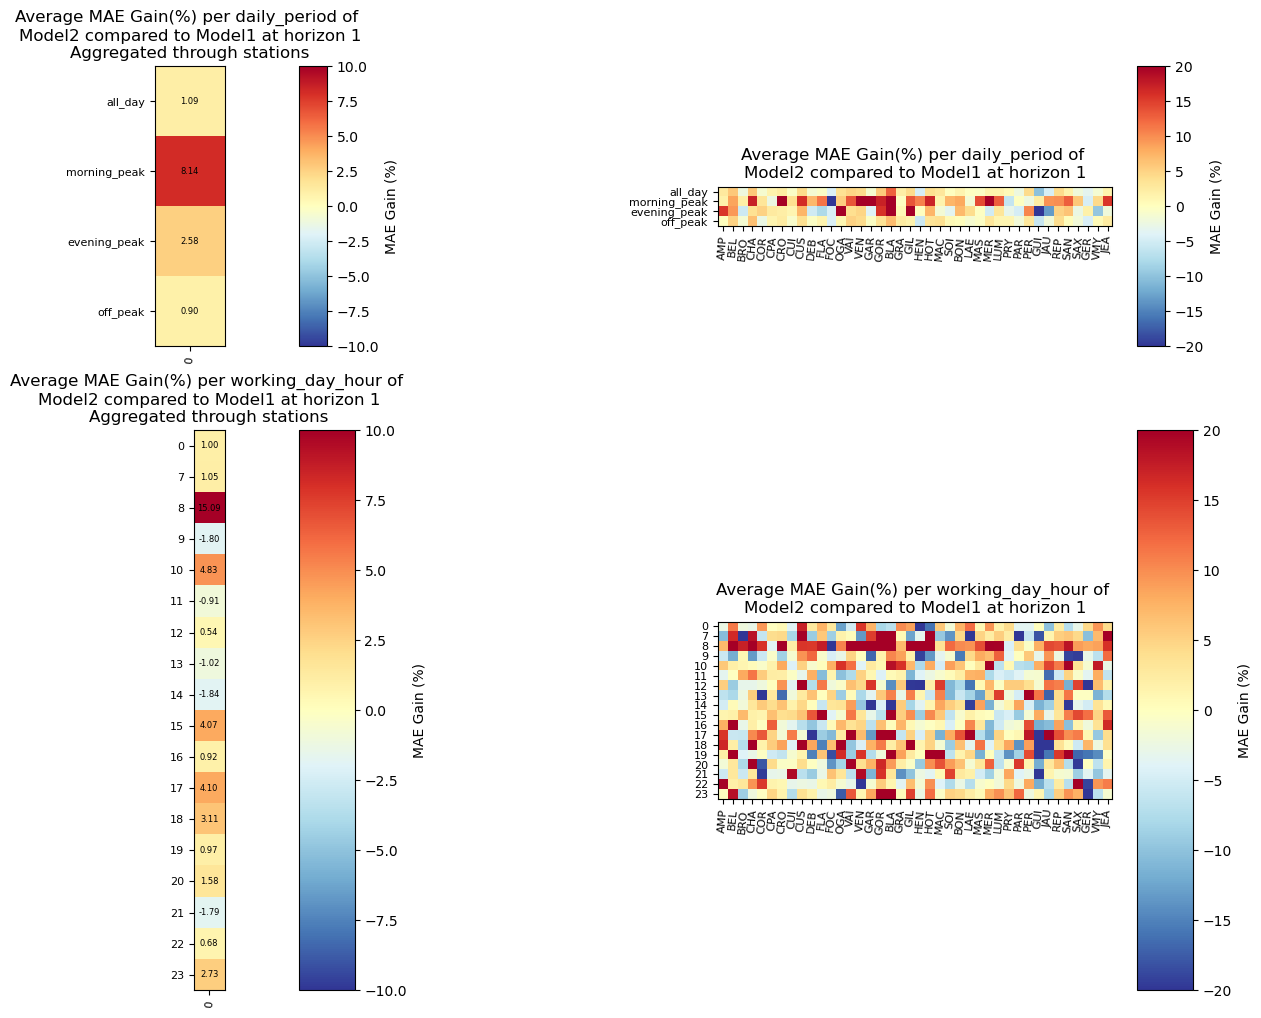

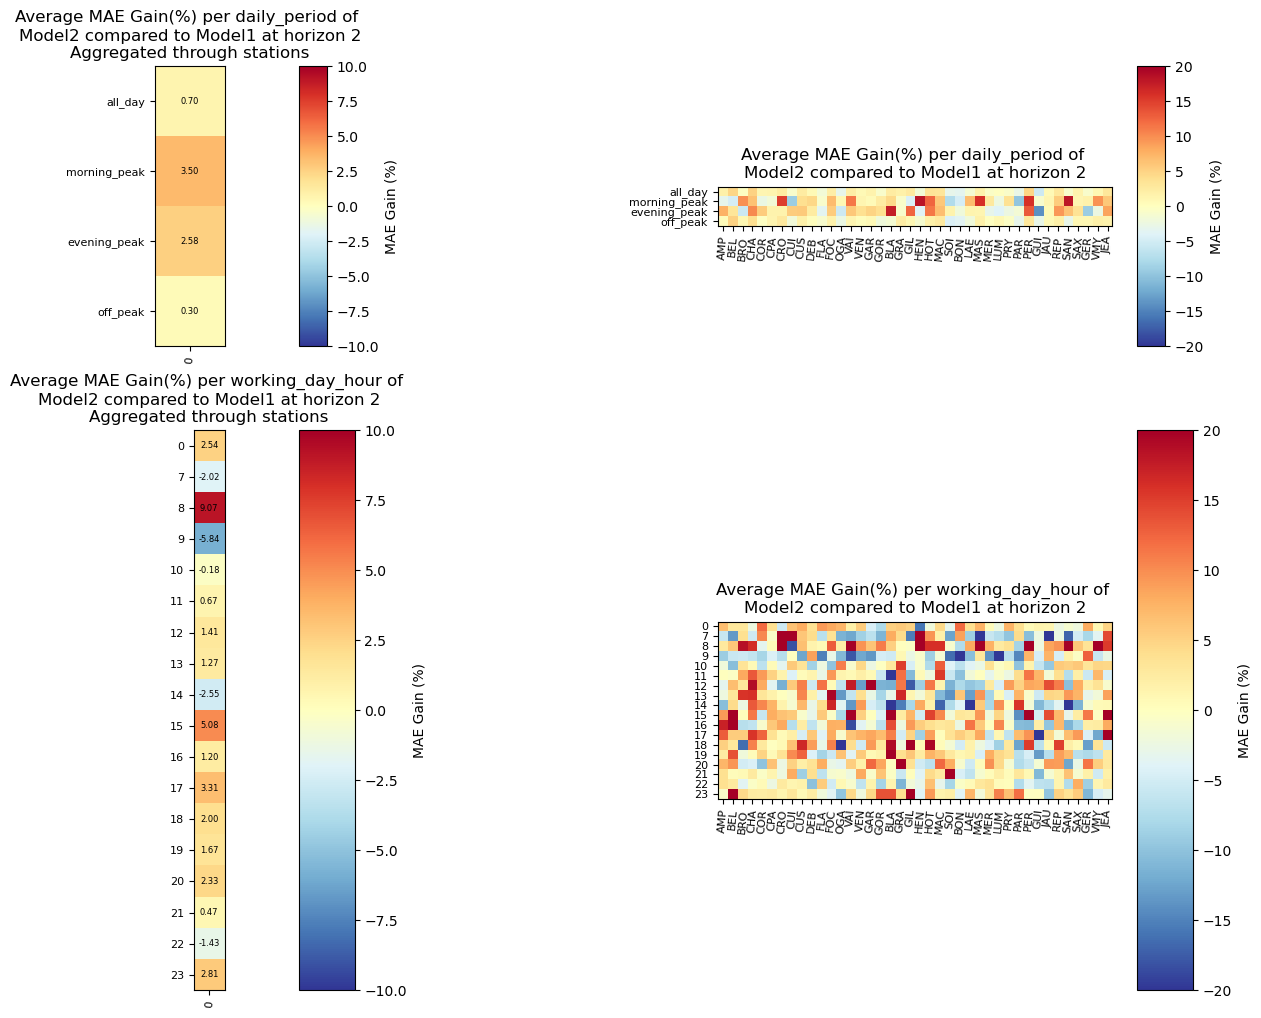

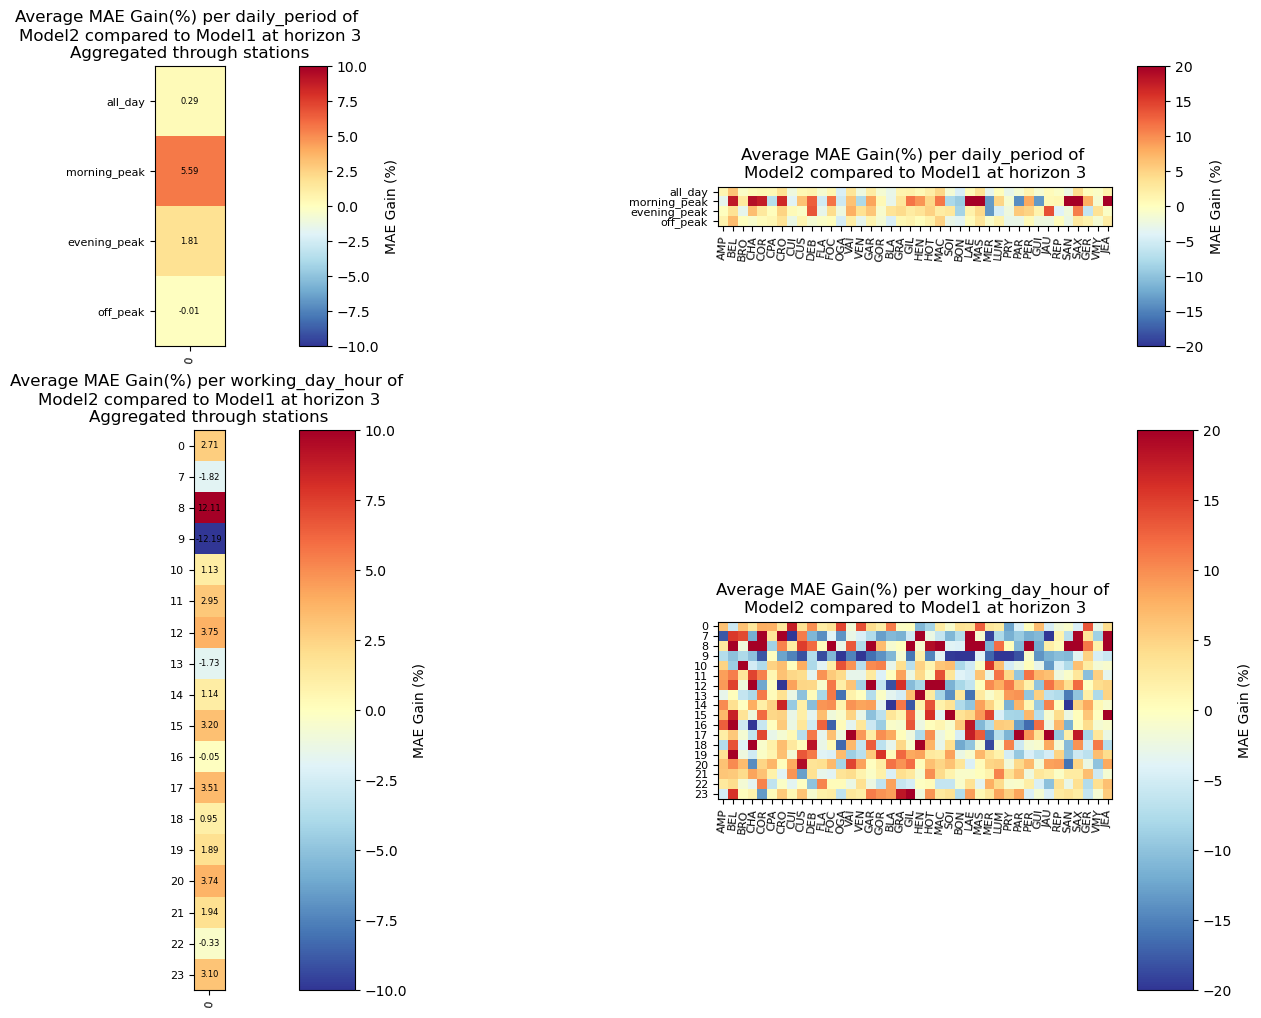

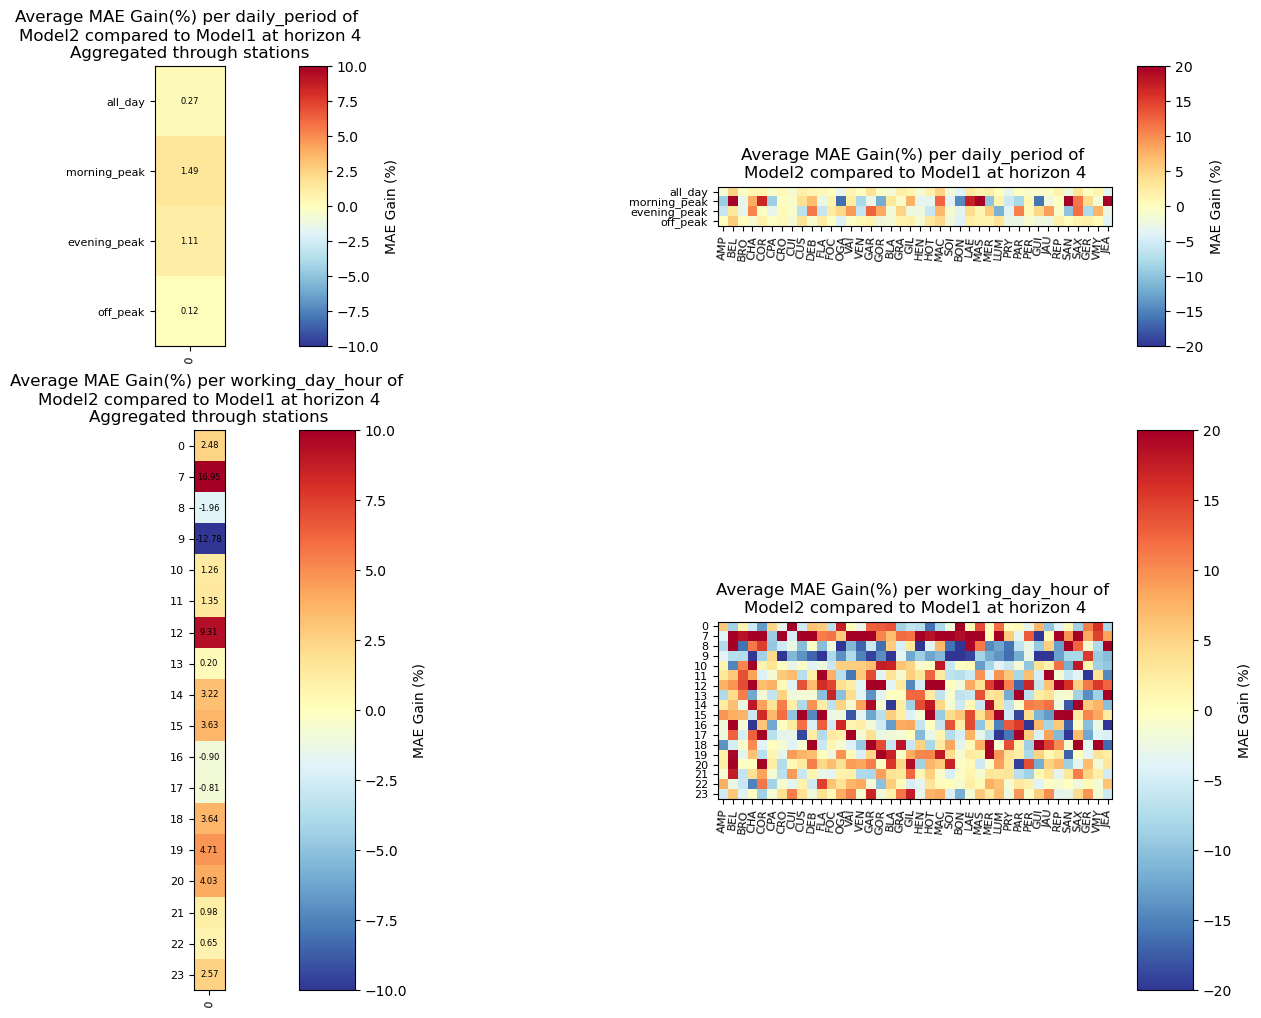

In [ ]:
min_flow = 20
step_ahead_max = args_init1.step_ahead
temporal_aggs =  ['daily_period','working_day_hour'] # ['hour','date','weekday'] 'hour', 'date', 'weekday', 'weekday_hour', 'weekday_hour_minute', 'daily_period', 'working_day_hour'
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
station_i = stations.index(station)
metric_list = ['mae'] # ['mae','mase','rmse']


# ---- Print global information ----
print_global_info(trial_id1,trial_id2,full_predict1,full_predict2,Y_true,ds1)
dic_error_agg_h = {}

# ---- plot gain between models ----
for step_ahead in range(args_init1.horizon_step,step_ahead_max+1,args_init1.horizon_step): # range(1,step_ahead_max+1):   
    h_idx = step_ahead// args_init1.horizon_step

    # Get previous and predictions
    previous,predict1,predict2,real = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,h_idx)

    # Plotting
    dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)
    dic_gain_agg,dic_error_agg = plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode,metrics = metric_list,step_ahead = step_ahead)  # ['mse','mase','mape']
    dic_error_agg_h[step_ahead] = dic_error_agg



# ---- plot temporal series profil of predictions ----
p = plot_profile_comparison_between_2_prediction(args_init1,full_predict1,full_predict2,real,ds1,station_i,station, width=900, height=400, bool_plot = True)


# ---- Print local inofrmation ----
for L_metric in [[metric] for metric in metric_list]:
    print(f'\nModel: {args_init1.model_name}')
    for daily_period in ['morning_peak','evening_peak','all_day']:
        print(daily_period)
        for metric in L_metric: 
            print(' ',metric.upper())
            if metric == 'rmse':
                metric_i = 'mse'
            else:
                metric_i = metric
            error1_per_h = [np.mean([dic_error_agg_h[h][metric_i]['daily_period']['error_pred1_agg'][station][daily_period] for station in ds1.spatial_unit]) for h in range(args_init1.horizon_step,step_ahead_max+1,args_init1.horizon_step)]
            error2_per_h = [np.mean([dic_error_agg_h[h][metric_i]['daily_period']['error_pred2_agg'][station][daily_period] for station in ds1.spatial_unit]) for h in range(args_init1.horizon_step,step_ahead_max+1,args_init1.horizon_step)]
            if metric == 'rmse':
                error1_per_h = [np.sqrt(x) for x in error1_per_h]
                error2_per_h = [np.sqrt(x) for x in error2_per_h]

            print('   Model 1: ',error1_per_h)
            print('   Model 2: ',error2_per_h)
# import numpy as np 
# for metric in ['mae']:
#     print(f'\nGlobal {metric.upper()} gain (%):')
#     for peak_name in ['morning_peak','evening_peak','off_peak']:
#         print(f"  {peak_name}: {'{:.3}'.format(np.mean([dic_gain[metric]['daily_period'][c][peak_name] for c in ds1.spatial_unit]))}%")

# Load Both models to compare : 

In [2]:
modification = {'shuffle':False,
                'data_augmentation':False
                'freq':'15min'}

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Load Model2: 
#Trained Model with Subway-in / Subway-out 
if False:
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

#Trained Model with Subway-in / NetMob POI:
if False: 
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    #add_name_id2 = 'NETMOB_POIS_maps_Twitter_concat_early_late_UL_DL_all_tags'
    add_name_id2 = 'NETMOB_POIS_maps_Deezer_concat_early_DL_IRIS'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713


## Have a look on some interpolation:

In [3]:
# 'DA_method': 'magnitude_warping'
# 'DA_method': 'rich_interpolation'
# 'DA_method': 'interpolation'

modification = {'shuffle':False,
                'DA_method' : ['magnitude_warping','rich_interpolation'],
                'data_augmentation' : True 
                }


save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id2 = 'concat_early'
trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

training_mode = 'train'
inputs = [[x,y,x_c] for  x,y,x_c in ds2.dataloader[training_mode]]
nb_contextual_data = len(inputs[0][2])
X = torch.cat([x for x,_,_ in inputs],0).to(trainer2.args.device)
Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer2.args.device)
X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer2.args.device)  for k in range(nb_contextual_data)]
X_c_one = [torch.ones(x_c.size()).to(trainer2.args.device) for x_c in X_c]

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
2821 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modifi

<Axes: >

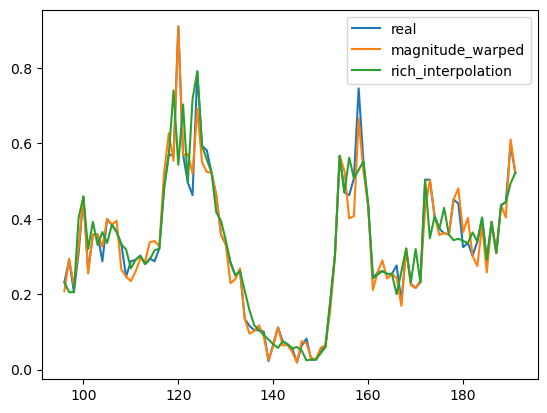

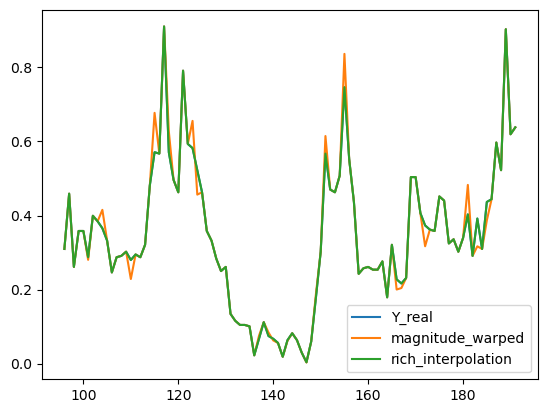

In [10]:
n = X.size(0)//3
station_i = 0

L = -3

pd.DataFrame({'real': X[:n,station_i,L].detach().cpu(),
              'magnitude_warped':X[n:2*n,station_i,L].detach().cpu(),
              'rich_interpolation':X[2*n:,station_i,L].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()


pd.DataFrame({'Y_real': Y_true[:n,station_i,0].detach().cpu(),
              'magnitude_warped':Y_true[n:2*n,station_i,0].detach().cpu(),
               'rich_interpolation':Y_true[2*n:,station_i,0].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()

## Get Metrics from trained model. Compared consistency with saved one : 
Nous permets de nous assurer qu'on à bien sauvegarder le meilleur model, et que c'est bien celui qu'on Load.

In [4]:
def display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test'):
    full_predict1,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    df_metrics1 = pd.read_csv(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/METRICS_{trial_id}{add_name_id}.csv")
    display(df_metrics1)
    print(f"MSE errror on {training_mode} by loading trained model : {'{:.2f}'.format(error_pred1.item())}\n")

In [3]:
display_consistency(trainer1,ds1,save_folder1,trial_id1,add_name_id1,training_mode = 'test')
display_consistency(trainer2,ds2,save_folder2,trial_id2,add_name_id2,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1250.633032,20.827599,34.545302,8210.072104,0.396348,11.819149,1157.247070,19.905209,30.030531
1,test,1306.318921,21.229312,33.583765,1632.788441,0.561886,37.853172,1319.264526,20.539398,28.160223


MSE errror on test by loading trained model : 1319.26



,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1230.919019,20.847181,36.719215,5382.383880,0.558646,6.967195,1128.664185,19.996849,33.227039
1,test,1288.185107,21.260062,36.229020,4998.188979,1.045187,84.935830,1286.441650,20.617752,29.995420


MSE errror on test by loading trained model : 1286.44



## Checking if Contetual Data are taken into account
- Set the Tensor associated to contextual data as 0 Tensor 
- Do the prediction 
- Compare the associated metrics

In [9]:
def check_impact_of_contextual_data(trainer,ds,training_mode = 'test'):
    inputs = [[x,y,x_c] for  x,y,x_c in ds.dataloader[training_mode]]
    nb_contextual_data = len(inputs[0][2])
    X = torch.cat([x for x,_,_ in inputs],0).to(trainer.args.device)
    Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer.args.device)
    X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer.args.device)  for k in range(nb_contextual_data)]
    X_c_one = [torch.ones(x_c.size()).to(trainer.args.device) for x_c in X_c]

    trainer.model.eval()
    with torch.no_grad():
        Preds = trainer.model(X,X_c)
        Preds_no_contextual = trainer.model(X,X_c_one)
        
    Preds = Preds.detach().cpu()
    Preds_no_contextual = Preds_no_contextual.detach().cpu()
    Y_true = Y_true.detach().cpu()
    Preds = ds.normalizer.unormalize_tensor(inputs = Preds,feature_vect = True).reshape(-1)     #  device = self.args.device
    Preds_no_contextual = ds.normalizer.unormalize_tensor(inputs = Preds_no_contextual,feature_vect = True).reshape(-1)     #  device = self.args.device
    Y_true = ds.normalizer.unormalize_tensor(inputs = Y_true,feature_vect = True).reshape(-1)     # device = self.args.device

    error_pred1 = ((Y_true - Preds)**2).mean()
    error_pred_contextual_null = ((Y_true - Preds_no_contextual)**2).mean()

    print(f"MSE errror on {training_mode} set by loading trained model :\nWith contectual data: {'{:.2f}'.format(error_pred1.item())}")
    print(f"Without contectual data: {'{:.2f}'.format(error_pred_contextual_null.item())}")
    print(f"Associated MSE Gain {'{:.1%}'.format(1-error_pred1.item()/error_pred_contextual_null.item())}")

check_impact_of_contextual_data(trainer2,ds2,training_mode = 'test')

MSE errror on test set by loading trained model :
With contectual data: 1286.44
Without contectual data: 2206.18
Associated MSE Gain 41.7%


## Production de Visuel :

In [ ]:
# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
min_flow = 20

full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode)
previous,predict1,predict2,real = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,step_ahead,step_ahead_max)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

## Get Naiv Error and Model1 Error: 

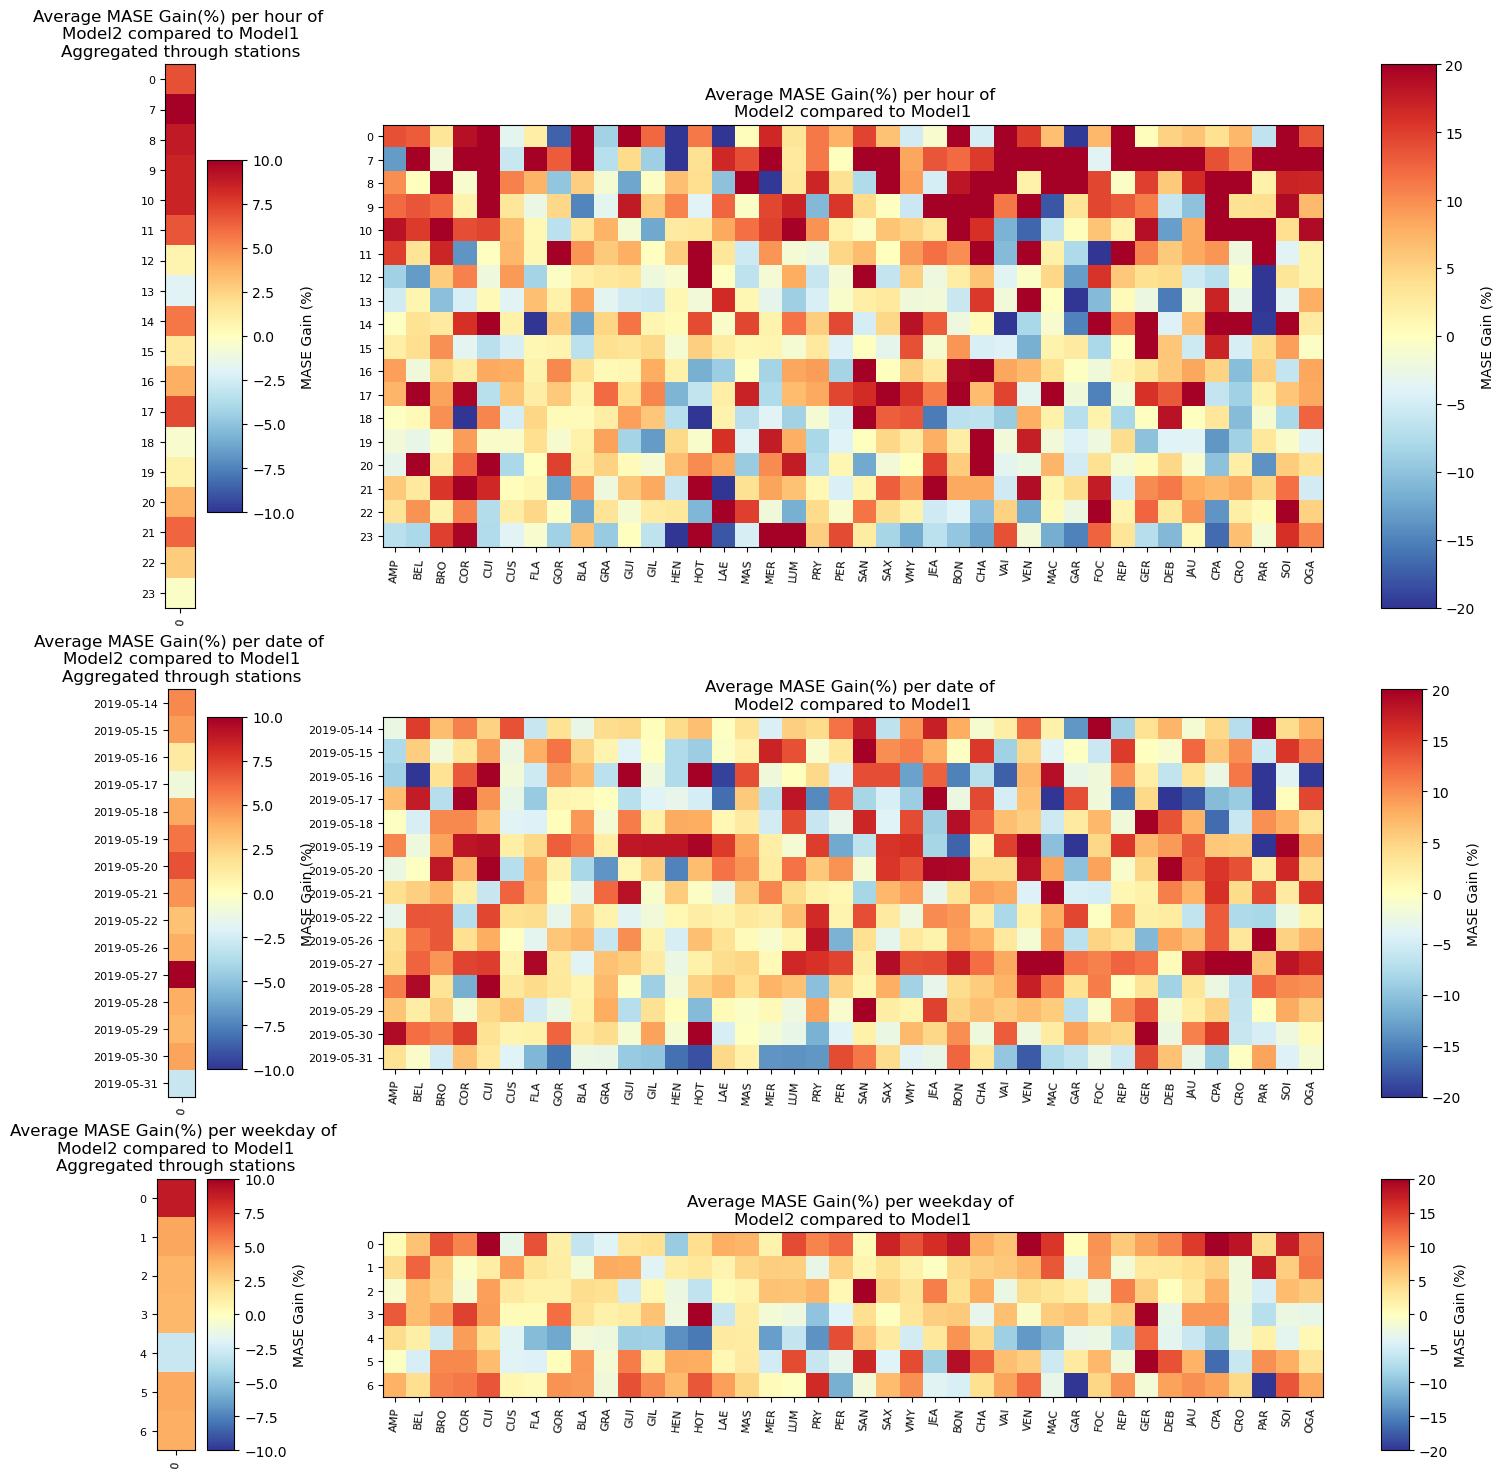

In [6]:
temporal_aggs = ['hour','date','weekday']
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)


plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode)

"""
fig, axes = plt.subplots(len(temporal_aggs), 2, figsize=(max(8,0.5*len(stations)),6*len(temporal_aggs)),gridspec_kw={'width_ratios': [1,5],'height_ratios': [4,3,2]})
for i,temporal_agg in enumerate(temporal_aggs):
    df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    # agg All sations  
    plt.sca(axes[i,0])
    plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_gain21).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-10,v_max=10)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1\nAggregated through stations'
    axes[i,0].set_title(title)

    # Per station 
    plt.sca(axes[i,1])
    plot_coverage_matshow(pd.DataFrame(df_gain21),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-20,v_max=20)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1'
    axes[i,1].set_title(title) 
"""


## Load Data 

In [ ]:
modification_bis = {'train_pourcent' : 100}

target_data = 'PeMS08_flow'#'PeMS08_flow'#'CRITER_3_4_5_lanes_flow' #'subway_in'  # PeMS03 # PeMS04 # PeMS07 # PeMS08 # METR_LA # criter
dataset_names = ['PeMS08_flow'] # ['CRITER_3_4_5_lanes_flow','netmob_POIs']  #['CRITER_3_4_5_lanes_flow']#['PeMS08_flow','PeMS08_occupancy','PeMS08_speed'] # ['subway_in','calendar_embedding'] #['PeMS03'] #['subway_in'] ['subway_in','subway_indiv'] #["subway_in","subway_out"] # ['subway_in','netmob_POIs_per_station'],["subway_in","subway_out"],["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage =['PeMS08_flow'] # ['CRITER_3_4_5_lanes_flow','netmob_POIs'] #['PeMS08_flow'] # ['subway_in','netmob_image_per_station']#['subway_in','subway_indiv'] # ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STAEformer'

config_file = importlib.import_module(f"constants.config_by_datasets.{target_data}.{model_name}")
importlib.reload(config_file)
modification = config_file.config
SEED = config_file.SEED
set_seed(SEED)
modification.update(modification_bis)
args_init = local_get_args(model_name,
                args_init = None,
                dataset_names=dataset_names,
                dataset_for_coverage=dataset_for_coverage,
                modification = modification)


trainer,ds  = load_trainer_ds_from_1_args(args_init,modification = modification)


for training_mode in ['train','valid','test']:
    print('\nTraining mode: ',training_mode)
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)


    predicted_dates = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1]
    mini_d,maxi_d = predicted_dates.min(),predicted_dates.max()
    print(f'    X,Y,X_c size: ',X.size(),Y.size(),[xc.size() for xc in X_c])
    print(f'    Predicted dates ({len(predicted_dates)}): {mini_d} - {maxi_d}' )
    print(f'    Supposed to contains: {len(pd.date_range(mini_d,maxi_d,freq=f"{int(60/ds.time_step_per_hour)}min"))} dates')

## Plot Time Series on specific station: 

<Axes: >

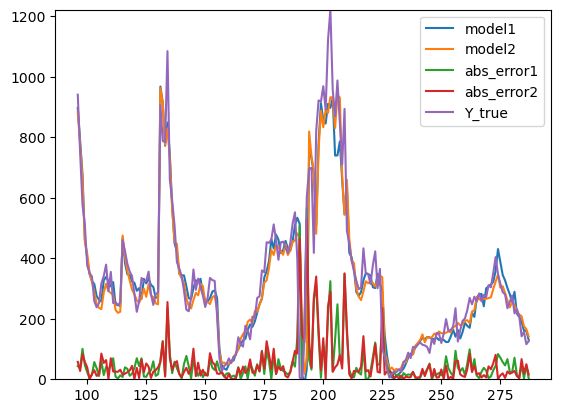

In [6]:
station = 'BEL'
start_day = 1
nb_days = 2


station_i = list(ds1.spatial_unit).index(station)
pred1 = predict1[:,station_i].numpy()
pred2 = predict2[:,station_i].numpy()
ytrue = real[:,station_i].numpy()

error_abs1 = dic_error['mae']['error_pred1'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
error_abs2 = dic_error['mae']['error_pred2'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
naive_error = dic_error['mae_naiv']['error_naiv'].reshape(-1,len(ds1.spatial_unit))[:,station_i]

ax = pd.DataFrame({'model1':pred1,
              'model2':pred2,
              'abs_error1':error_abs1,
              'abs_error2':error_abs2,
              'Y_true':ytrue 
              }).iloc[start_day*96:96*(start_day+nb_days)]
ax.plot(ylim = [0,ytrue[start_day*96:96*(start_day+nb_days)].max()])

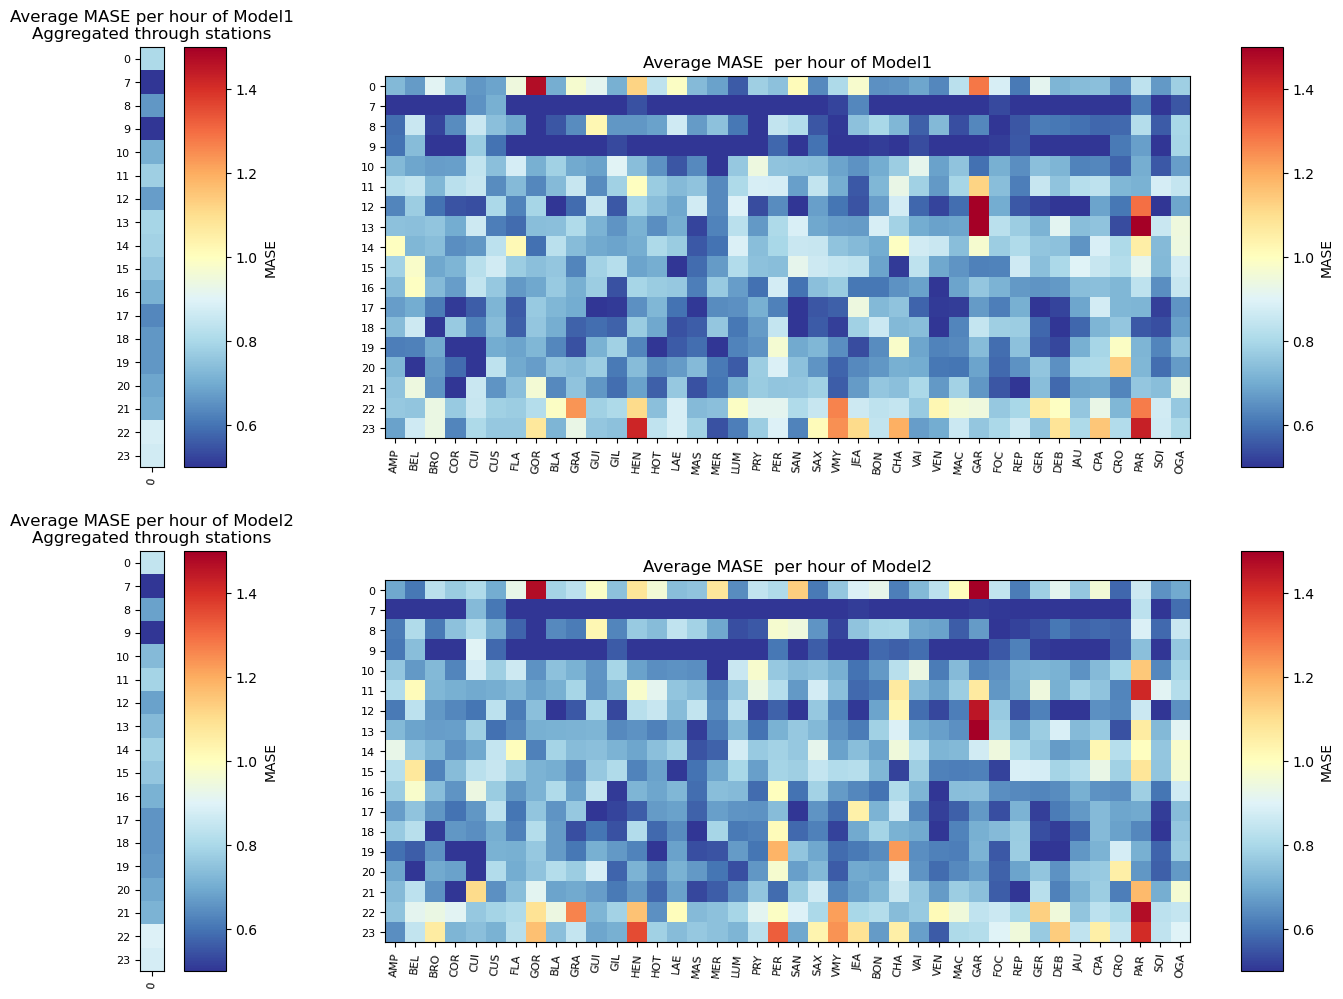

In [10]:
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
temporal_aggs = ['hour'] #['weekday_hour_minute','weekday_hour','hour','date','weekday']
for temporal_agg in temporal_aggs:
    fig, axes = plt.subplots(2, 2, figsize=(max(8,0.5*len(stations)),get_y_size_from_temporal_agg(temporal_agg)),gridspec_kw={'width_ratios': [2,5]})
    df_gain21,df_mase1,df_mase2 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    for i,df_mase in enumerate([df_mase1,df_mase2]):
        # agg All sations  
        plt.sca(axes[i,0])
        plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_mase).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE per {temporal_agg} of Model{i+1}\nAggregated through stations'
        axes[i,0].set_title(title)

        # Per station 
        plt.sca(axes[i,1])
        plot_coverage_matshow(pd.DataFrame(df_mase),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE  per {temporal_agg} of Model{i+1}'
        axes[i,1].set_title(title) 


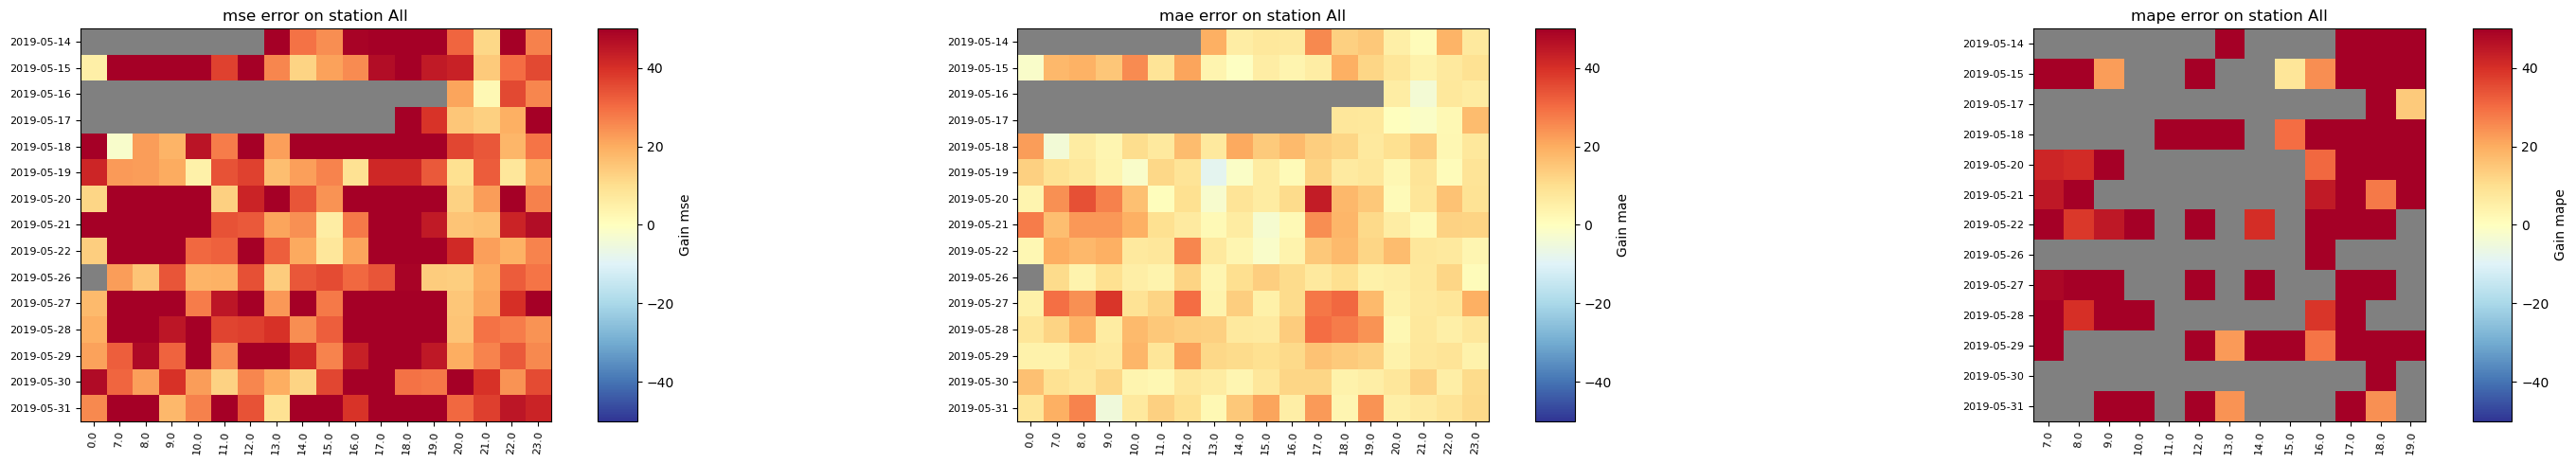

(<Figure size 3000x500 with 6 Axes>,
 array([<Axes: title={'center': 'mse error on station All'}>,
        <Axes: title={'center': 'mae error on station All'}>,
        <Axes: title={'center': 'mape error on station All'}>],
       dtype=object))

In [11]:
station = ['PAR','PER','GER','BON']
training_mode = 'test'

# index_matshow in :  ['weekday','hour','month_year','date','day_date']
# columns_matshow in :  [None, 'weekday','hour','month_year','date','day_date']

gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station,
                        plot_each_station = False,
                        plot_all_station = True)

## Visualisation des coeff d'attentions :

In [ ]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)
temporal_agg = 'hour'  # weekday_hour_minutes','hour','weekday','weekday_hour'
training_mode = 'test'
station = ['CHA','PAR','PER']
plot_attn_weight(trainer,nb_calendar_data,ds,training_mode = training_mode,stations= station,temporal_agg =temporal_agg,save=None)

In [3]:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/'
add_name_id1 = ''
trial_id1 ='subway_in_subway_out_STGCN_MSELoss_2025_02_20_22_43_85017'
trainer,ds,args = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification={})

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
T_subway_out:  torch.Size([7392, 40])
vision_input_type POIs
vision_model_name None
2821 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([5642, 40, 7]) torch.Size([5642, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481
Considered Spatial-Unit:  Index(['AMP', 'BEL', 'BRO', 'COR', 'CUI', 'CUS', 'FLA', 'GOR', 'BLA', 'GRA',
       'GUI', 'GIL', 'HEN', 'HOT', 'LAE', 'MAS', 'MER', 'LUM', 'PRY', 'PER',
       'SAN', 'SAX', 'VMY', 'JEA',

In [6]:
layer = 0
training_mode = 'test'
attn_model = trainer.model.core_model.output.temporal_agg.layers[layer].attention.sublayer.heads
num_heads = len(attn_model)

X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)

In [11]:
import gc
import torch.nn as nn 
gc.collect()
torch.cuda.empty_cache()

original_temporal_agg = trainer.model.core_model.output.temporal_agg
model_until_temporal_MHA = trainer.model
model_until_temporal_MHA.core_model.output.temporal_agg = nn.Identity()


trainer.model.eval()
with torch.no_grad():
    intermediate_output = model_until_temporal_MHA(X,X_c)

gc.collect()
torch.cuda.empty_cache()

In [12]:
intermediate_output.size()

torch.Size([940, 40, 1])

In [ ]:

for head in attn_model:
    enhanced_x,attn_weights = head(X,X_c)

In [ ]:
def plot_attn_weight(trainer,nb_calendar_data,ds= None,training_mode = None,temporal_agg = None,save=None,stations= None,layer = None):
    attn_model = trainer.model.core_model.output.temporal_agg.layers[layer].attention.sublayer.heads
    num_heads = len(attn_model)
    
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)

    # Init:
    nb_contextuals = len(X_c) - nb_calendar_data
    spatial_units = list(ds.spatial_unit)
    if stations is not None :
        nb_stations_to_plot = len(stations) 
    else :
        stations = list(ds.spatial_unit)
        nb_stations_to_plot = Y.size(1)
    num_cols = 4

    nb_rows = (nb_stations_to_plot*num_heads + num_cols - 1) // num_cols  
    y_size = get_y_size_from_temporal_agg(temporal_agg)
    #plt.figure(figsize=(5*num_cols,y_size))  
    plt.figure(figsize=(5*num_cols*max(1,nb_stations_to_plot//15),int(y_size*max(1,nb_contextuals//num_cols))))

    vmin,vmax = 0,min(1,1/(nb_contextuals/3)) 
    for station_i in range(nb_stations_to_plot):

        station_ind  = spatial_units.index(stations[station_i])

        enhanced_x,attn_weights = attn_model[station_ind](X[:,station_ind,:],X_c[station_ind+nb_calendar_data],x_known = None)
        if attn_weights.dim()==4:
            for attn_head_i in range(num_heads):
                attn_weights_reshaped = attn_weights[:,attn_head_i,:,:].squeeze(1).detach().cpu().numpy()  # Shape [B, P]
                # Temporal Aggregation of attn weight:
                attn_weights_reshaped,str_dates = temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg)
                ax = plt.subplot(nb_rows, num_cols, station_i*num_heads+attn_head_i + 1)  # Créer un subplot
                im = ax.imshow(attn_weights_reshaped, cmap='hot', aspect='auto',vmin=vmin,vmax=vmax)
                plt.colorbar(im,label='Attention Weight',shrink = 0.25)
                
                if temporal_agg is None:
                    plt.title(f'Attention Weight head {attn_head_i}\nof station {station_ind} ({spatial_units[station_ind]}) \nfor each sample of the batch')
                    plt.ylabel('Samples')
                else:
                    plt.title(f'Mean Attention Weight head {attn_head_i}\nof station {station_i}({spatial_units[station_ind]}) \nby calendar class') 
                    plt.ylabel('Calendar class')
                plt.xlabel('Contextual time-series')


                num_samples, nb_contextual_on_plot_i = attn_weights_reshaped.shape
                plt.xticks(ticks=np.arange(nb_contextual_on_plot_i), labels=[f'Unit {i}' for i in range(nb_contextual_on_plot_i)], rotation=45)
                plt.yticks(ticks=np.arange(num_samples), labels=str_dates)

    plt.tight_layout()

    if save is not None:
        plt.savefig(f'{save}.pdf',format = 'pdf',bbox_inches='tight')
    plt.show()

## Fine Tuning on Specific Moments : 
- !!! ICI besoin de 'shuffle = True' parce qu'on train le model (fine-tuning)

## Fly-by transit:
#### Concept existants:
- Stop-Less Autonomous Modular (SLAM) (testé à dubai en 2018) : micro bus qui peuvent se concatener si besoin (opour en faire des plus gros), et qui sont indépendant également si beson . Permet de distribuer correctement les usagers selon leur destinations. A Dubai: 6 seats et 4 debout par mini bus (capacity 10).
L'idée c'est d'arrêter de faire des stops. 
- AMB aussi à produit des prototype du henre.

Limite dans le cas d'utilisation 'massive': pas inclusif, les vieux peuvent pas aler d'un module à un autre. Même pour marcher entre deux module c'est pas incroyable. Puis dans tout les cas on a jamais 2 passagers qui ont les mêmes OD. 
#### Leur proposition: 
proposer leur propre model mais en préservant la dimension 'transport public'. 
Propose de décomposer en tout petit moduel, pour 1 a 2 personne. Pouvant se mettre par exemple en platoon etc.
## Question : 
- que faire dnas le cas où bu va d'un point A à un point B, dont la majorité de ses usagers font ce trajet ?
- Enormement de 'sous module': technologie embarquée, seat à laver après chaque utilisation/journée, réparation etc... finalement pas de coût de driver mais énormément d'autres coûts, s'assurer en permanance de la sécurité de chaque unité (high speed, donc dangereux), les réparations etc...
- Utilisation de la capacité 'urbaine': acutellement beaucoup de congestion. ça ne devrait pas les aider, d'autant plus que si on permet à tout le monde de se déplacer ça va encourager des 'micro' déplacement', qui prennent de la place sur le réseau (contrairement à des mobilités douces types vélo, ou contrairement a des gros system de transport type metro / bus grande capacité).
- C'est moins cher que le Taxi par personne transporté. Mais on ne veut pas un taxi par personne.  comparaiosn avec un model non souhaitable.
- Compare le prix avec une voiture éléctrique. Mais la on parle d'un truc autonome.
- Surement des moment et endroit où quand la demande est importante, il y a aura des centaines de Trailers qui devront se déplacer au même endroit, et ça va générer d'énorme problème logistique.


## Benchmark Comparison between models: 

In [1]:
import pandas as pd
from examples.benchmark import local_get_args,keep_track_on_model_metrics
from examples.train_and_visu_non_recurrent import train_the_config,get_ds_without_shuffling_on_train_set
from plotting.TS_analysis import plot_TS


def get_TS_prediction(trainer,ds,stations_to_plot='CHA',training_mode='test',name= ''):
    spatial_units  = list(ds.spatial_unit)
    station_indices = [spatial_units.index(station) for station in stations_to_plot]
    predict,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    df_pred =  pd.DataFrame({f'{name}_{spatial_units[station_i]}_Pred':predict[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    df_true = pd.DataFrame({f'{spatial_units[station_i]}_Y_true': Y_true[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    index_df = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].values
    return df_pred,df_true,index_df

Training and Hyper-parameter tuning with Ray is not possible


Training and Hyper-parameter tuning with Ray is not possible
>>>>Model: CNN; K_fold = 6; Loss function: MSE 
>>>>Model: CNN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940
Considered Spatial-Unit:  None
Model size: 0.000GB
number of total parameters: 1889
number of trainable parameters: 1889

start training
epoch: 0 
 min\epoch : 0.08
Estimated time for training: 2.0min 

Training Throughput:3139.53 sequences per seconds
>>> Training complete in: 0:01:56.890262
>>> Training performance time: min 0.00694584846496582 avg 0.009059906005859375 seconds (+/- 0.006282888286802044)
>>> Loading performance time: min 0.00015854835510253906 avg 0.0062623259501425775 seconds (+/- 0.014081617299986991)
>>> Forward performance time: 0.0009820986656757377 sec

Loading BokehJS ...

<Axes: >

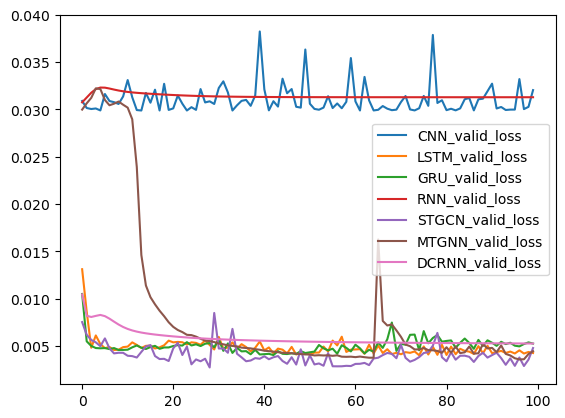

In [1]:
dataset_for_coverage = ['subway_in','netmob_POIs']
dataset_names = ['subway_in']
save_folder = 'benchmark/fold0/'
df_results,df_loss_tot,df_pred_all_models = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

modification = {'epochs' : 100, #100,
                'hp_tuning_on_first_fold': False,
                'keep_best_weights':True

                }

stations_to_plot = ['CHA']
training_mode = 'test'
model_names =['CNN','LSTM','GRU','RNN','STGCN','MTGNN','DCRNN']   # Attention Graph ???
dict_trainers = {}
for model_name in model_names:
    args = local_get_args(model_name,
                            args_init = None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = modification)
    fold_to_evaluate = [args.K_fold -1]
    trainer,ds,args,trial_id,df_loss = train_the_config(args,modification,fold_to_evaluate)
    trainer,ds_no_shuffle = get_ds_without_shuffling_on_train_set(trainer,modification,args,fold_to_evaluate)


    metrics = trainer.metrics
    df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer.performance,trainer.metrics)
    #dict_trainers[model_name] = trainer
    # Get TS prediction on Test Dataset
    df_loss_tot = pd.concat([df_loss_tot,df_loss],axis=1)
    df_pred,df_true,index_df = get_TS_prediction(trainer,ds,stations_to_plot=stations_to_plot,training_mode=training_mode,name= model_name)
    df_pred_all_models = pd.concat([df_pred_all_models,df_pred],axis=1)
    print(df_results)

# Concat with 'Y_true'
df_pred_all_models = pd.concat([df_pred_all_models,df_true],axis=1)
df_pred_all_models.index = index_df
plot_TS(df_pred_all_models,width=1400,height=400,bool_show=True,title='Comparison of Prediction Quality')

df_loss_tot[[f"{model}_valid_loss" for model in model_names]].plot()


In [2]:
df_results

,Model,Valid_loss,Valid_mse,Test_mse,Valid_mae,Test_mae,Valid_mape,Test_mape
0,CNN,0.029883,18683.888672,17581.490234,92.898766,87.686371,284.523895,218.150238
0,LSTM,0.004042,2056.194824,2027.486328,27.648268,27.326344,40.493713,36.615929
0,GRU,0.004063,2078.000488,2051.144531,27.521818,27.205008,45.601322,40.368877
0,RNN,0.030743,19329.923828,18687.574219,90.831963,86.728508,242.366821,185.635788
0,STGCN,0.002752,1368.745239,1421.312134,22.125439,22.203094,38.124065,34.790466
0,MTGNN,0.003603,1870.807617,1942.013184,26.149363,26.374453,46.093781,40.294285
0,DCRNN,0.005282,2824.918213,2873.498779,31.813610,32.829212,57.927681,54.280727


>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940
Considered Spatial-Unit:  None
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713

start training
epoch: 0 
 min\epoch : 1.29
Estimated time for training: 18.8min 

Training Throughput:692.55 sequences per seconds
>>> Training complete in: 0:05:10.429930
>>> Training performance time: min 0.014720678329467773 avg 0.02728891372680664 seconds (+/- 0.06569723933859964)
>>> Loading performance time: min 0.00013709068298339844 avg 0.03701392448955633 seconds (+/- 0.6139421012670077)
>>> Forward performance time: 0.031157050568967972 seconds (+/- 0.06124145142530242)
>>> Backward performance time:

Loading BokehJS ...

<Axes: >

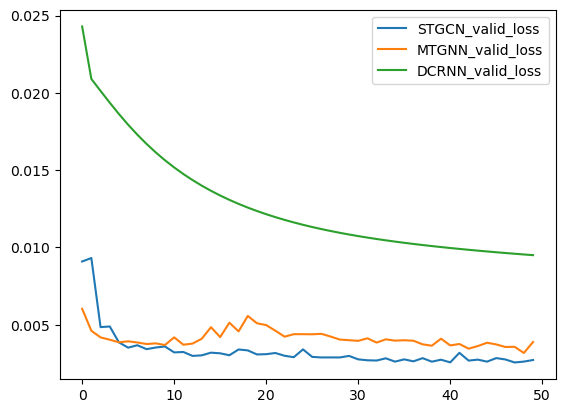

In [2]:
dataset_for_coverage = ['subway_in','netmob_POIs']
dataset_names = ['subway_in']
save_folder = 'benchmark/fold0/'

df_results,df_loss_tot,df_pred_all_models = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
modification = {'epochs' : 50, #100,
                'lr': 0.00135,
                'weight_decay': 0.0733390536333296,
                'batch_size': 32,
                'dropout': 0.3187398629441463,
                'scheduler': None,
                'hp_tuning_on_first_fold': False,
                'keep_best_weights':True
                }

stations_to_plot = ['CHA']
training_mode = 'test'
model_names =['STGCN','MTGNN','DCRNN']   # Attention Graph ???
dict_trainers = {}

for model_name in model_names:
    args = local_get_args(model_name,
                            args_init = None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = modification)
    fold_to_evaluate = [args.K_fold -1]
    trainer,ds,args,trial_id,df_loss = train_the_config(args,modification,fold_to_evaluate)
    trainer,ds_no_shuffle = get_ds_without_shuffling_on_train_set(trainer,modification,args,fold_to_evaluate)


    metrics = trainer.metrics
    df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer.performance,trainer.metrics)
    #dict_trainers[model_name] = trainer
    # Get TS prediction on Test Dataset
    df_loss_tot = pd.concat([df_loss_tot,df_loss],axis=1)
    df_pred,df_true,index_df = get_TS_prediction(trainer,ds,stations_to_plot=stations_to_plot,training_mode=training_mode,name= model_name)
    df_pred_all_models = pd.concat([df_pred_all_models,df_pred],axis=1)
    print(df_results)

# Concat with 'Y_true'
df_pred_all_models = pd.concat([df_pred_all_models,df_true],axis=1)
df_pred_all_models.index = index_df
plot_TS(df_pred_all_models,width=1400,height=400,bool_show=True,title='Comparison of Prediction Quality')

df_loss_tot[[f"{model}_valid_loss" for model in model_names]].plot()

In [7]:
from examples.load_best_config import load_args_of_a_specific_trial
add_name_id = ''
trial_id ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
save_folder = 'K_fold_validation/training_with_HP_tuning/re_validation'
fold_name = 'complete_dataset'
args = load_args_of_a_specific_trial(trial_id,add_name_id,save_folder,fold_name)
args.lr

0.00135

In [10]:
for arg_i in ['lr','weight_decay','batch_size','dropout','scheduler']:
    print(f"'{arg_i}': {getattr(args,arg_i)},")

'lr': 0.00135,
'weight_decay': 0.0733390536333296,
'batch_size': 32,
'dropout': 0.3187398629441463,
'scheduler': nan,
